# Imports

In [34]:
import matplotlib.pyplot as plt
import numpy as np

#import pandas as pd
import os 

import h5py
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

resize_transform = transforms.Resize( (256, 128) )

if(torch.cuda.is_available()):
    count = torch.cuda.device_count();
    print("CUDA is available and can be used by", count, "device(s).");
    curr_device =  torch.cuda.current_device();
    curr_device_name = torch.cuda.get_device_name(0);
    print("Device",curr_device, ", referring to the GPU", curr_device_name, ", is in use by torch")
else:
    print("CUDA is unavailable");

CUDA is available and can be used by 4 device(s).
Device 0 , referring to the GPU NVIDIA A100-SXM4-80GB , is in use by torch


In [35]:
tracking_results_direc = '/global/cfs/cdirs/m669/riverr/2DCSR/results_lucretia_beams/'
beam_direc= '/global/cfs/cdirs/m669/riverr/2DCSR/lucretia_beams/'

In [36]:
def load_step(file, n_step, directory = tracking_results_direc, emit = False): # load one step from a simulation file 
    file_name = directory + f'/{file}';#f'2DCSR_NN_lucretia/{file}'
    #print(file_name)
    h5 = h5py.File(file_name, 'r');

    result = h5['csr_result'];
    #print(result.keys())
    nz, nx = result["Ws_grid_list"][n_step].T.shape ## number of grid points in z and x for wakes 
    nz_cg, nx_cg = result["lambda_grid_list"][n_step].T.shape ## number of grid points in z and x for beam density 
    ## lambda and rho both refer to beam density
    zmin = result["zmin_list"][n_step]; ## minimum z coordinate
    zmax = result["zmax_list"][n_step];
    xmin = result["xmin_list"][n_step];
    xmax = result["xmax_list"][n_step];

    zv = np.linspace(zmin, zmax, nz);
    xv = np.linspace(xmin, xmax, nx);

    zv_cg = np.linspace(zmin, zmax, nz_cg);
    xv_cg = np.linspace(xmin, xmax, nx_cg);

    Ws_grid = result["Ws_grid_list"][n_step].T;
    Wx_grid = result["Wx_grid_list"][n_step].T;
    lambda_grid = result["lambda_grid_list"][n_step].T;

    s = np.array(result["s_at_kick_list"])[n_step];
    if emit:
        epsx = np.array(result["emit_at_kick_list"])[n_step];
        epsx_0 = np.array(result["emit_disp_free_at_kick_list"])[n_step];
        return xv, zv, Ws_grid, Wx_grid, lambda_grid, s, epsx, epsx_0 ;
    else:
        
        return xv, zv, Ws_grid, Wx_grid, lambda_grid, s;

In [37]:
#%%time
ns = np.arange(20);  # 20 steps per simulation

sim_data = [];
for j, file in enumerate(os.listdir(tracking_results_direc)):
    if (not file.startswith('result')):
        continue;

    
    # Load first step
    xv, zv, Ws, Wx, rho, s = load_step(file, 0);

    Ws = Ws[:-1, :-1];
    Wx = Wx[:-1, :-1];
    rho = rho[:];

    dx = np.mean(np.diff(xv));  # Physical scaling in x
    dz = np.mean(np.diff(zv)); # Ditto in y

    Ws = np.expand_dims(Ws, axis= 0);    # Add a new axis at the beginning
    Wx = np.expand_dims(Wx, axis= 0);    # Ditto
    rho = np.expand_dims(rho, axis= 0);  # Ditto 
    
    # Convert to numpy arrays
    
    Ws = torch.from_numpy(Ws); Wx = torch.from_numpy(Wx); rho = torch.from_numpy(rho); dx = torch.from_numpy(np.array([dx]));
    dz = torch.from_numpy(np.array([dz])); s = torch.from_numpy(np.array([s]));

    curr_dict = { 'Ws_data': Ws, 'Wx_data': Wx, 'rho_data': rho, 'dx_data': dx, 'dz_data': dz, 's_data': s};
    
    if file.startswith('result'):
        for i, n in enumerate(ns):
            #Load data for this timestep
            xv, zv, Ws, Wx, rho, s = load_step(file, n);
            Ws = Ws[:-1, :-1];
            Wx = Wx[:-1, :-1];
            rho = rho[:];

            dx = np.mean(np.diff(xv));  # Physical scaling in x
            dz = np.mean(np.diff(zv));  # Ditto in y

            Ws = np.expand_dims(Ws, axis= 0);   # Add a new axis at the beginning
            Wx = np.expand_dims(Wx, axis= 0);    # Ditto
            rho = np.expand_dims(rho, axis= 0);  # Ditto
            #Cast into pytorch tensors
            curr_dict['Ws_data'] = torch.cat((torch.from_numpy(Ws), curr_dict['Ws_data']), dim= 0);
            curr_dict['Wx_data'] = torch.cat((torch.from_numpy(Wx), curr_dict['Wx_data']), dim= 0);
            curr_dict['rho_data'] = torch.cat((torch.from_numpy(rho), curr_dict['rho_data']), dim= 0);
            curr_dict['dx_data'] = torch.cat((torch.from_numpy(np.array([dx])), curr_dict['dx_data']));
            curr_dict['dz_data'] = torch.cat((torch.from_numpy(np.array([dz])), curr_dict['dz_data']));
            curr_dict['s_data'] = torch.cat((torch.from_numpy(np.array([s])), curr_dict['s_data']));
        
        i_0 = file.find('P2_'); i_0 += 3;
        P2 = file[i_0:-3];
        P2 = float(P2);
        curr_dict['P2'] = P2;
        sim_data.append(curr_dict);
try: 
    del curr_dict;
except:
    pass;

In [38]:
len(sim_data)

61

### Now we'd like to filter the data and exclude certain phases to see if the network is capable of extrapolation.

### Some of the data are particularly noisy, so we will impose a scaled blur onto the wakefield and density data (i.e. Gaussian blur + rescale to keep total average wake value constant)

### TODO: Check if smoothed images produce same tracking output as originals in simulation

$$ \sigma_{x} \cdot (\frac{1}{R \sigma_{z}^2})^{\frac{1}{3}} $$

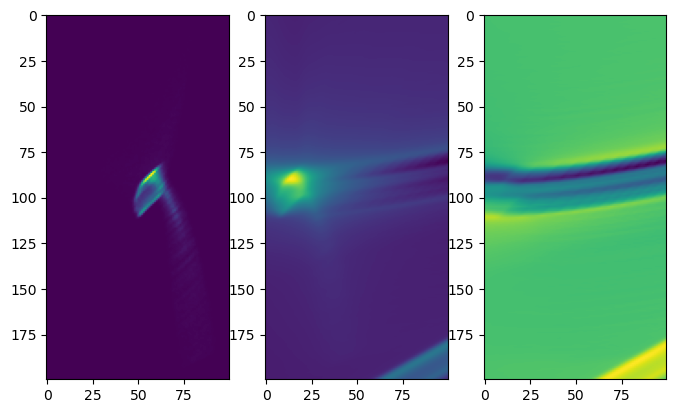

In [39]:
Ws = sim_data[3]['Ws_data'][0]
Wx = sim_data[3]['Wx_data'][0]
rho = sim_data[3]['rho_data'][0]

fig, ax = plt.subplots(1,3, figsize = (8,8));
ax[0].imshow(rho);
ax[1].imshow(Wx);
ax[2].imshow(Ws);

In [40]:
import skimage;
import skimage.filters;

def gaussian_blur(img, sigmax = 0 , sigmay = 2):
    blurred_img = skimage.filters.gaussian(
    img, sigma=(sigmay, 0), truncate=3.5
    );
    fac = float(img.mean()/blurred_img.mean());
    blurred_img *= fac;
    return blurred_img;

In [41]:
"""for sim in sim_data:
    for j, img in enumerate(sim['Ws_data']):
        sim['Ws_data'][j] = torch.DoubleTensor(gaussian_blur(img));
    for j, img in enumerate(sim['Wx_data']):
        sim['Wx_data'][j] = torch.DoubleTensor(gaussian_blur(img));
    for j, img in enumerate(sim['rho_data']):
        sim['rho_data'][j] = torch.DoubleTensor(gaussian_blur(img));"""

"for sim in sim_data:\n    for j, img in enumerate(sim['Ws_data']):\n        sim['Ws_data'][j] = torch.DoubleTensor(gaussian_blur(img));\n    for j, img in enumerate(sim['Wx_data']):\n        sim['Wx_data'][j] = torch.DoubleTensor(gaussian_blur(img));\n    for j, img in enumerate(sim['rho_data']):\n        sim['rho_data'][j] = torch.DoubleTensor(gaussian_blur(img));"

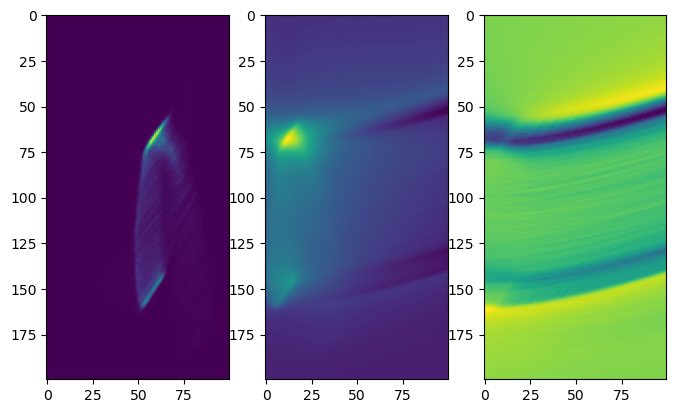

In [42]:
Ws = sim_data[5]['Ws_data'][0]
Wx = sim_data[5]['Wx_data'][0]
rho = sim_data[5]['rho_data'][0]

fig, ax = plt.subplots(1,3, figsize = (8,8))
ax[0].imshow(rho);
ax[1].imshow(Wx);
ax[2].imshow(Ws);

## Now we ought to sort out the data into a training set, a testing set, and a validation set

## We'll do this by excluding certain simulations with prescriped phases from the training

In [43]:
L2Arr = []
for i in range(len(sim_data)):
    L2Arr += [sim_data[i]['P2']]

L2Arr.sort();

In [44]:
excluded_phases = L2Arr[-4:];
N = len(excluded_phases)*len(sim_data[0]['Ws_data']);
print(f"{N} phases excluded from training");

84 phases excluded from training


In [45]:
ns = np.arange(20);  # 20 steps per simulation

# Arrays for training data
Ws_training = torch.tensor([]);
Wx_training = torch.tensor([]);
rho_training = torch.tensor([]);
dx_training = torch.tensor([]);
dz_training = torch.tensor([]);
s_training = torch.tensor([]);

# Arrays for validation data
Ws_training = torch.tensor([]);
Wx_training = torch.tensor([]);
rho_training = torch.tensor([]);
dx_training = torch.tensor([]);
dz_training = torch.tensor([]);
s_training = torch.tensor([]);

# Arrays for testing data
Ws_testing = torch.tensor([]);
Wx_testing = torch.tensor([]);
rho_testing = torch.tensor([]);
dx_testing = torch.tensor([]);
dz_testing = torch.tensor([]);
s_testing = torch.tensor([]);

for sim in sim_data:
    if sim['P2'] in excluded_phases:
        Ws_testing = torch.cat((sim['Ws_data'], Ws_testing), dim= 0);
        Wx_testing = torch.cat((sim['Wx_data'], Wx_testing), dim= 0);
        rho_testing = torch.cat((sim['rho_data'], rho_testing), dim= 0);
        dx_testing = torch.cat((sim['dx_data'], dx_testing), dim= 0);
        dz_testing = torch.cat((sim['dz_data'], dz_testing), dim= 0);
        s_testing = torch.cat((sim['s_data'], s_testing), dim= 0);
        
    else:
        Ws_training = torch.cat((sim['Ws_data'], Ws_training), dim= 0);
        Wx_training = torch.cat((sim['Wx_data'], Wx_training), dim= 0);
        rho_training = torch.cat((sim['rho_data'], rho_training), dim= 0);
        dx_training = torch.cat((sim['dx_data'], dx_training), dim= 0);
        dz_training = torch.cat((sim['dz_data'], dz_training), dim= 0);
        s_training = torch.cat((sim['s_data'], s_training), dim= 0);
# Reshape the images
Ws_training = resize_transform(Ws_training)
Wx_training = resize_transform(Wx_training)
rho_training = resize_transform(rho_training)

Ws_testing = resize_transform(Ws_testing)
Wx_testing = resize_transform(Wx_testing)
rho_testing = resize_transform(rho_testing)

Ws_training = torch.unsqueeze(Ws_training, dim = 1);
Wx_training = torch.unsqueeze(Wx_training, dim = 1);
rho_training = torch.unsqueeze(rho_training, dim = 1);

Ws_testing = torch.unsqueeze(Ws_testing, dim = 1);
Wx_testing = torch.unsqueeze(Wx_testing, dim = 1);
rho_testing = torch.unsqueeze(rho_testing, dim = 1);

In [46]:
print(Ws_training.shape)
print(s_training.shape)

torch.Size([1197, 1, 256, 128])
torch.Size([1197])


In [47]:
# Split up into training, validation, and testing batches
ntrain = 3500
train_idx = np.unique(np.random.randint(0, len(Ws_training), ntrain)) # pick training indices randomly 
remaining_idx = [i for i in range(Ws_training.shape[0]) if i not in train_idx] # remaining indices available
print(len(train_idx), "training examples");
val_idx = remaining_idx
print(len(val_idx), "validation examples");


Ws_train = Ws_training[train_idx];
Ws_val = Ws_training[val_idx];


Wx_train = Wx_training[train_idx];
Wx_val = Wx_training[val_idx];

rho_train = rho_training[train_idx];
rho_val = rho_training[val_idx];


dx_train = dx_training[train_idx];
dx_val = dx_training[val_idx];

dz_train = dz_training[train_idx];
dz_val = dz_training[val_idx];

s_train = s_training[train_idx];
s_val = s_training[val_idx];

1136 training examples
61 validation examples


In [48]:
Ws_train.shape

torch.Size([1136, 1, 256, 128])

In [49]:
%%time

Ws_data = torch.cat((Ws_training, Ws_testing), dim = 0);
Wx_data = torch.cat((Wx_training, Wx_testing), dim = 0);
rho_data = torch.cat((rho_training, rho_testing), dim = 0);
dx_data = torch.cat((dx_training, dx_testing), dim = 0);
dz_data = torch.cat((dx_training, dx_testing), dim = 0);
s_data = torch.cat((s_training, s_testing), dim = 0);

CPU times: user 772 ms, sys: 1.15 s, total: 1.92 s
Wall time: 30.3 ms


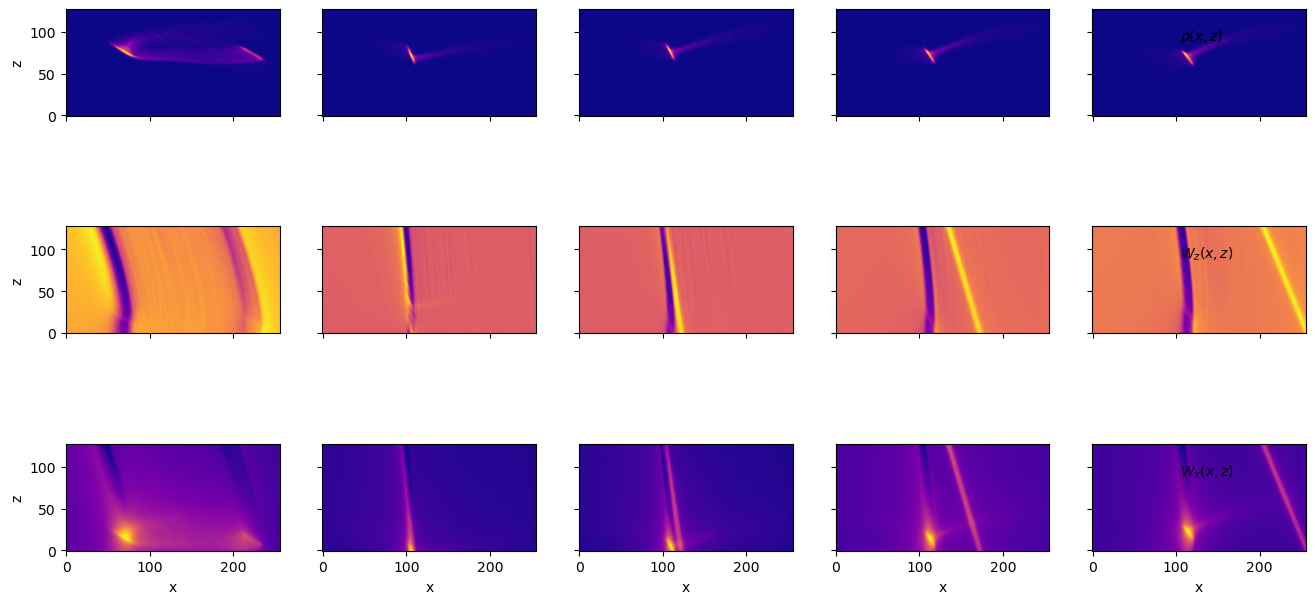

In [50]:
# look at a few example images 

fig, ax = plt.subplots(3,5, figsize= (16, 8), sharex=True, sharey=True)

indices = [ 0,  -5, -10, -15, -19]#[410, 1400, 500, 100, 1210]
for i in range(len(indices)):
    ax[0,i].imshow(rho_train[indices[i],0,:,:].T, origin='lower', cmap='plasma')
    ax[1,i].imshow(Ws_train[indices[i],0,:,:].T, origin='lower', cmap='plasma')
    ax[2,i].imshow(Wx_train[indices[i],0,:,:].T, origin='lower', cmap='plasma')

ax[0,-1].text(105, 90, r'$\rho(x,z)$')
ax[1,-1].text(105, 90, r'$W_z(x,z)$')
ax[2,-1].text(105, 90, r'$W_x(x,z)$')
for i in range(len(indices)):
    ax[2,i].set_xlabel('x')

ax[0,0].set_ylabel('z');
ax[1,0].set_ylabel('z');
ax[2,0].set_ylabel('z');

#fig.savefig("images.png", dpi=400, bbox_inches='tight')

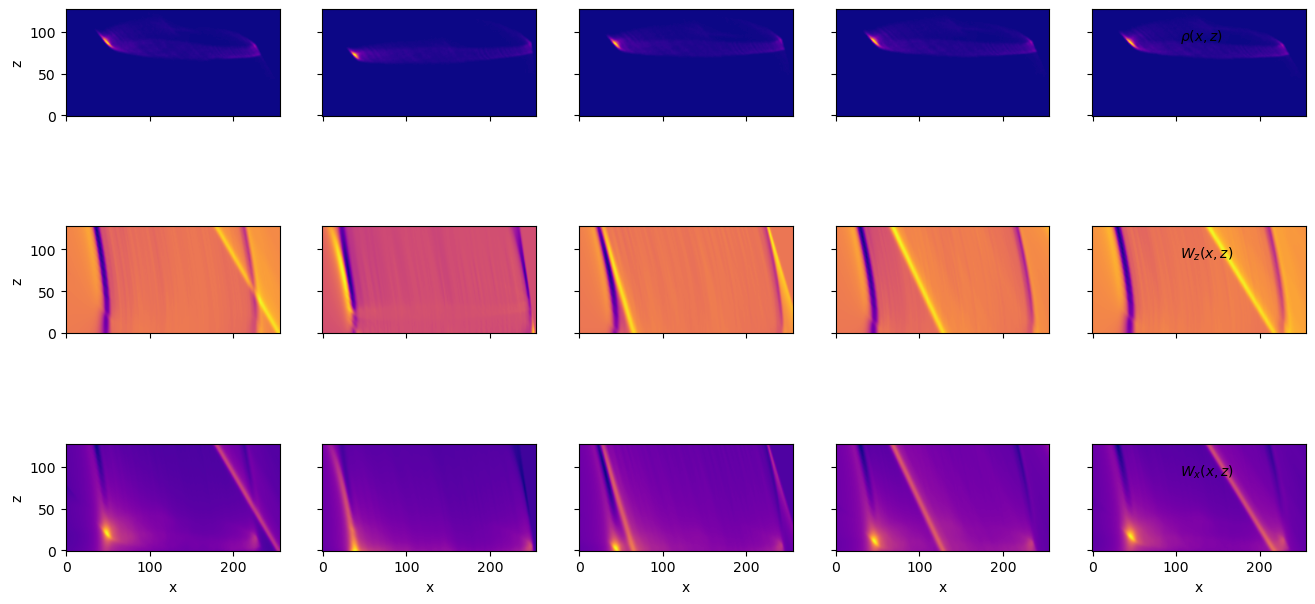

In [51]:
# look at a few example TESTING images 

fig, ax = plt.subplots(3,5, figsize= (16, 8), sharex=True, sharey=True)

indices = [ 0,  -5, -10, -15, -19]#[410, 1400, 500, 100, 1210]
for i in range(len(indices)):
    ax[0,i].imshow(rho_testing[indices[i],0,:,:].T, origin='lower', cmap='plasma')
    ax[1,i].imshow(Ws_testing[indices[i],0,:,:].T, origin='lower', cmap='plasma')
    ax[2,i].imshow(Wx_testing[indices[i],0,:,:].T, origin='lower', cmap='plasma')

ax[0,-1].text(105, 90, r'$\rho(x,z)$')
ax[1,-1].text(105, 90, r'$W_z(x,z)$')
ax[2,-1].text(105, 90, r'$W_x(x,z)$')
for i in range(len(indices)):
    ax[2,i].set_xlabel('x')

ax[0,0].set_ylabel('z');
ax[1,0].set_ylabel('z');
ax[2,0].set_ylabel('z');

#fig.savefig("images.png", dpi=400, bbox_inches='tight')

In [52]:
%%time
# Computing normalization factors
norm_rho = torch.tensor([img.max() for img in rho_data]).min();#Minimum peak charge density in data 
norm_rho_train = torch.tensor([img.max() for img in rho_train]) ;# Peak charge density in each validation image 
norm_rho_val = torch.tensor([img.max() for img in rho_val]) ;# Peak charge density in each val image
norm_rho_test = torch.tensor([img.max() for img in rho_testing]) ;# Peak charge density in each test image 
norm_Ws = torch.tensor([img.max() for img in Ws_data]).min(); #Minimum peak charge density in data
norm_Wx = torch.tensor([img.max() for img in Wx_data]).min() #Minimum peak charge density in data
norm_dx = 1e-6 # Scale factor for transverse pixel width 
norm_dz = 1e-9 # Scale factor for longitudinal pixel width 
#norm_rho_scale= norm_rho.min()# Minimum peak charge density in training set for normalization (infsup)
#norm_rho_scale2= norm_rho_test.min()# Minimum peak charge density in training set for normalization (infsup)

CPU times: user 65.1 ms, sys: 3.22 ms, total: 68.3 ms
Wall time: 66.8 ms


In [53]:
%%time
#See what happens without normalization

#rho_train /= norm_rho # normalize training images 
#rho_val /= norm_rho # normalize validation images 
#rho_testing /= norm_rho # normalize test images 
norm_Ws = 1e5;
norm_Wx = 1e3;
Ws_train /= norm_Ws # normalize training images 
Ws_val /= norm_Ws; # normalize validation images
Ws_testing /= norm_Ws # noramlize test images 

r= 1;#(1/2)*(Ws_data.abs().mean()/norm_Ws)/(Wx_data.abs().mean()/norm_Wx)

Wx_train /= norm_Wx/r # normalize training images
Wx_val /= norm_Wx/r # normalize validation images
Wx_testing /= norm_Wx/r # normalize test images


CPU times: user 493 ms, sys: 17.6 ms, total: 511 ms
Wall time: 8.69 ms


In [54]:
print(f"{abs(Ws_train).max():.2E}")

1.75E+01


In [55]:
#%%time

scalar_train = np.stack((dx_train, dz_train, s_train, norm_rho_train), axis=1)
scalar_val = np.stack((dx_val, dz_val, s_val, norm_rho_val), axis=1)
scalar_test = np.stack((dx_testing, dz_testing, s_testing, norm_rho_test), axis=1)


scalar_train[:,0] /= norm_dx # normalize transverse pixel width in training set
scalar_train[:,1] /= norm_dz # normalize longitudinal pixel width in training set 

scalar_val[:,0] /= norm_dx # normalize transverse pixel width in val set 
scalar_val[:,1] /= norm_dz # normalize longitudinal pixel width in val set 

scalar_test[:,0] /= norm_dx # normalize transverse pixel width in test set 
scalar_test[:,1] /= norm_dz # normalize longitudinal pixel width in test set 

In [56]:
%%time
scalar_train = torch.from_numpy(scalar_train).float()
scalar_val = torch.from_numpy(scalar_val).float()
scalar_test = torch.from_numpy(scalar_test).float()

CPU times: user 705 µs, sys: 81 µs, total: 786 µs
Wall time: 552 µs


In [57]:
%%time
W_train = np.concatenate((rho_train, rho_train),axis= 1) # shape train wake images into two channels
W_train = torch.tensor(W_train)

W_val = np.concatenate((rho_val, rho_val),axis= 1) # shape test wake images into two channels
W_val = torch.tensor(W_val)

W_testing= np.concatenate((rho_testing, rho_testing),axis= 1) # shape test wake images into two channels
W_testing  = torch.tensor(W_testing)

CPU times: user 2.09 s, sys: 895 ms, total: 2.98 s
Wall time: 123 ms


In [58]:
%%time
W_train = np.concatenate((Ws_train, Wx_train),axis= 1) # shape train wake images into two channels
W_train = torch.tensor(W_train)

W_val = np.concatenate((Ws_val, Wx_val),axis= 1) # shape test wake images into two channels
W_val = torch.tensor(W_val)

W_testing= np.concatenate((Ws_testing, Wx_testing),axis= 1) # shape test wake images into two channels
W_testing  = torch.tensor(W_testing)


CPU times: user 2.76 s, sys: 629 ms, total: 3.39 s
Wall time: 130 ms


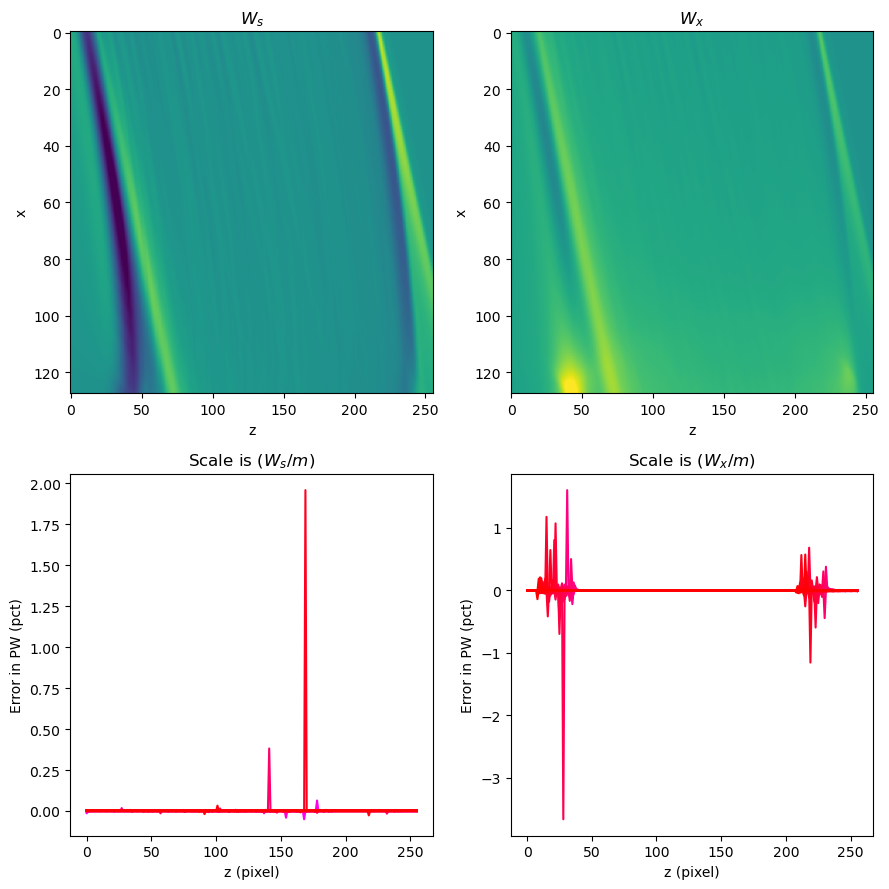

In [59]:
# Looking at Panofsky-Wenzel, just for funsies

ind = 200;
Ws = np.array(Ws_data[ind].squeeze(0));
Wx = np.array(Wx_data[ind].squeeze(0));
Nz = Ws.shape[0];
Nx = Ws.shape[1];
Dx_Ws = np.gradient(Ws, axis = 1, edge_order = 2);
Dz_Wx = np.gradient(Wx, axis = 0, edge_order = 2);
Ws_scale = np.max(np.abs(Ws))
Wx_scale = np.max(np.abs(Wx))
PW_err = (Dx_Ws - (Dz_Wx)/(1e3) )/(Ws_scale);

fig,ax = plt.subplots(2,2, figsize = (9,9))

cbar_max = 1.2*np.max(np.array(Ws))
cbar_min = 0.90*np.min(np.array(Ws))


ax[0,0].imshow(np.flip(Ws.T, axis = 0), vmin=cbar_min, vmax=cbar_max, aspect='auto')
ax[0,0].set_title('$W_s$')
ax[0,0].set_xlabel('z');
ax[0,0].set_ylabel('x');

ax[0,1].imshow(np.flip(Wx.T*Ws_scale/Wx_scale, axis = 0), vmin=cbar_min, vmax=cbar_max, aspect='auto')
ax[0,1].set_title('$W_x$')
ax[0,1].set_xlabel('z');
ax[0,1].set_ylabel('x');

#ax[1,0].plot(Wx[:,0], label='$rot(W)$')
for i in range(len(PW_err.T)):
    ax[1,0].plot(100*PW_err.T[i]/(1+Ws.T[i]), c = (1,0,1-i/len(PW_err.T)))
    #ax[1,0].plot(Ws.T[i]/(1e6), c = (0,0,i/len(PW_err.T)))
ax[1,0].set_title('Scale is $(W_{s}/m$)')
ax[1,0].set_xlabel('z (pixel)')
ax[1,0].set_ylabel('Error in PW (pct)')
for i in range(len(PW_err.T)):
    ax[1,1].plot(100*PW_err.T[i]/(1+Wx.T[i]), c = (1,0,1-i/len(PW_err.T)))
    #ax[1,0].plot(Ws.T[i]/(1e6), c = (0,0,i/len(PW_err.T)))
ax[1,1].set_title('Scale is $(W_{x}/m$)')
ax[1,1].set_xlabel('z (pixel)')
ax[1,1].set_ylabel('Error in PW (pct)')

fig.tight_layout()

#np.mean(PW_err/(Wx))/np.mean(Wx)
#np.mean(PW_err/(Ws))/np.mean(Ws)

# Define model

In [60]:
class CSR2D(nn.Module):
    def __init__(self):
        super().__init__()
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.uniform_(m.weight)
                m.bias.data.fill_(1)
            return;

        def weights_init_uniform_rule(m):
            #Alternative initialization procedure initiates weights uniformly; doesn't seem to make much of a difference
            classname = m.__class__.__name__
            if classname.find('Linear') != -1:
                # get the number of the inputs
                n = m.in_features
                mu = 0;
                y = 1.0/np.sqrt(n)
                m.weight.data.uniform_(mu-y,mu+ y)
                m.bias.data.fill_(0)      
            
        ######################################################################################
        ######################################################################################
        
        ##################
        # Encoder     ###
        ################
        """
        Takes 256x128 density input, applies alternating high (3x3) and low (7x7) convolution + maxpooling to
        produce a (2**(8- num_conv), 2**(8 - num_conv -1)) image with n_filters channels
        
        ISSUE: These activations keep dying, fast! What gives?
        
        """
        encoding_dim = 36     # Length of final encoded feature vector
        
        
        num_conv = 3;           # Number of convolutional layers
        nfilters = 36;
        kernel_sizes = (3,7);   #[3, 7]
        pool_size = 2;
        activation = nn.ReLU();
        #Input layer
        encoder_layers = [];
        #for kernel_size in kernel_sizes:
        encoder_layers.append(nn.Conv2d(1, nfilters, kernel_sizes, padding='same'))
        encoder_layers.append(activation)
        encoder_layers += [nn.BatchNorm2d(nfilters)] ;
        encoder_layers += [nn.MaxPool2d(2)] ;
            
        for i in range(num_conv-1):
            for kernel_size in kernel_sizes:
                encoder_layers.append(nn.Conv2d(nfilters, nfilters, kernel_size, padding='same'))
                encoder_layers.append(activation)
            encoder_layers += [nn.BatchNorm2d(nfilters)] ;
            encoder_layers += [nn.AvgPool2d(2)] ;
        
        self.encoder = nn.Sequential(*encoder_layers) ;
        #self.encoder.apply(weights_init_uniform_rule)
        #######################
        # Flatten          ###
        #####################
        """
        Pretty self explanatory. Takes in the output of the encoder and flattens into a linear data structure,
        of length  encoded_dims[0] * encoded_dims[1] * nfilters, suitable for a linear dense NN
        
        The scalar parameter vector is appended to this vector afterward
        """
        encoded_dims = (2**(8- num_conv), 2**(8 - num_conv -1));
        flattened_dim = encoded_dims[0] * encoded_dims[1] * nfilters;
        flatten = [];
        #flatten.append(torch.flatten);
        flatten.append(nn.Linear(flattened_dim, encoding_dim));
        flatten.append(activation);
        self.flatten = nn.Sequential(*flatten);
        
        #########################
        # Intermediate Layer ###
        #######################
        """
        Takes 1D feature + parameter array of length  encoded_dims[0] * encoded_dims[1] * nfilters
        In the final layer, the num_units output vector is unflattened into a single channel 32x16 image
        
        TODO: See if keeping geometric info (i.e. not collapsing encoder into a 1xN vector) yields better performance
        """
        num_dense = 2;
        num_scalars = 3;
        num_units = 64;
        activation = nn.ReLU();
        output_dims = (16,8);
        dense_layers = [];
        dense_layers.append(nn.Linear( encoding_dim + num_scalars , num_units) );
        dense_layers.append(activation);
        for i in range(1,num_dense):
            dense_layers.append( nn.Linear(num_units, num_units) );
            dense_layers.append( activation );
        dense_layers.append( nn.Linear(num_units, output_dims[0]*output_dims[1])  );
        dense_layers.append( activation );
        dense_layers.append(nn.Unflatten(1, (1,output_dims[0], output_dims[1]) )   );
        dense_layers.append( activation );
        self.intermediate = nn.Sequential(*dense_layers)
        #self.intermediate.apply(weights_init_uniform_rule)
        
        #####################
        # 2 Channel Decoder #
        ####################
        """
        Takes the 1x32x16 output of the dense layer, splits it into nfilters channels, performs convolution+upsampling,
        and collapses into a two channel output image with approximate 2:1 aspect ratio
        """
        num_deconv = 3; 
        nfilters = 32;
        kernel_sizes = (3,7);
        pool_size = 2;
        activation = nn.ReLU();
        decoder_layers = [];
        decoder_layers.append(nn.LazyConvTranspose2d(nfilters, kernel_sizes[0], padding= (0,0) ));
        decoder_layers.append(activation);
        decoder_layers.append(nn.LazyConvTranspose2d(nfilters, kernel_sizes[1], padding= (0,0) ));
        decoder_layers.append(activation);
        pads = [1,0,0];
        for i in range(1, num_deconv):
            for kernel_size in kernel_sizes:
                decoder_layers.append(nn.LazyConvTranspose2d(nfilters, kernel_size, padding= (pads[i%3], pads[i%3])) );
                decoder_layers.append(activation);
            decoder_layers.append(nn.BatchNorm2d(nfilters));
            decoder_layers.append(nn.Upsample(scale_factor=pool_size))
        decoder_layers.append(nn.LazyConvTranspose2d(nfilters, kernel_sizes[0], padding= (0,0) ));
        #decoder_layers.append(activation);
        decoder_layers.append(nn.LazyConvTranspose2d(2, kernel_sizes[1], padding= (0,0) ));
        decoder_layers.append(nn.LazyConvTranspose2d(nfilters, kernel_sizes[0], padding= (0,0) ));
        #decoder_layers.append(activation);
        decoder_layers.append(nn.LazyConvTranspose2d(2, kernel_sizes[1], padding= (0,0) ));
        #decoder_layers.append(activation);   
        self.decoder = nn.Sequential(*decoder_layers);
        #self.decoder.apply(weights_init_uniform_rule)
        #####################
        # 1 Channel Decoder #
        ####################
        """
        Takes the 1x32x16 output of the dense layer, splits it into nfilters channels, performs convolution+upsampling,
        and collapses into a two channel output image with approximate 2:1 aspect ratio
        """
        num_deconv = 4; 
        #nfilters = 32;
        kernel_sizes = (2,3);
        pool_size = 2;
        activation = nn.ReLU();
        decoder_layers = [];
        decoder_layers.append(nn.ConvTranspose2d(2, nfilters, kernel_sizes[0], padding= (0,0) ));
        decoder_layers.append(activation);
        decoder_layers.append(nn.Conv2d(nfilters, nfilters, kernel_sizes[1], padding= (0,0)));
        decoder_layers.append(activation);
        pads = [1,0,0];
        for i in range(0):
            for kernel_size in kernel_sizes:
                decoder_layers.append(nn.LazyConvTranspose2d(nfilters, kernel_size, padding= (pads[i%3], pads[i%3])) );
                decoder_layers.append(activation);
            decoder_layers.append(nn.BatchNorm2d(2));
            decoder_layers.append(nn.Upsample(scale_factor=pool_size))
        decoder_layers.append(nn.LazyConvTranspose2d(2, kernel_sizes, padding= (0,0) ));
        decoder_layers.append(activation);
        self.decoder_1d = nn.Sequential(*decoder_layers);
        #self.decoder.apply(weights_init_uniform_rule)
    ##########################################################################  
    def forward(self, inputs):
        img_inputs = inputs[0];
        scalar_inputs= inputs[1];
        encoded = self.encoder(img_inputs);
        #print(f"Feature map has encoded feature vector of shape ", encoded.shape);
        #return encoded;
        #encoded_flattened = self.flatten(torch.flatten(encoded,1));
        #print(f"Image has encoded feature vector of shape ", encoded_flattened.shape);
        #return encoded_flattened
        #print(f"Image has encoded feature vector of shape ", encoded_flattened.shape);
        #concatenated = torch.cat((encoded_flattened, scalar_inputs), dim=1)
        #print(f"Combined feature + param vector has shape ", concatenated.shape);
        #return concatenated;
        #afterNN = self.intermediate(concatenated);
        #print(f"Densely encoded output has shape ", afterNN.shape);
        #return afterNN;
        decoded = self.decoder(encoded);
        #print(f"Decoded output has shape ", decoded.shape);
        decoded = torchvision.transforms.CenterCrop((200, 100))(decoded);
        decoded = torchvision.transforms.Resize((256,128))(decoded);
        #print(f"Output has shape ", decoded.shape);
        return decoded;
    def forward_1d(self, inputs):
        img_inputs = inputs[0];
        scalar_inputs= inputs[1];
        encoded = self.encoder(img_inputs);
        #print(f"Feature map has encoded feature vector of shape ", encoded.shape);
        #return encoded;
        encoded_flattened = self.flatten(encoded);
        #print(f"Image has encoded feature vector of shape ", encoded_flattened.shape);
        #return encoded_flattened
        #print(f"Image has encoded feature vector of shape ", encoded_flattened.shape);
        concatenated = torch.cat((encoded_flattened, scalar_inputs), dim=1);
        #print(f"Combined feature + param vector has shape ", concatenated.shape);
        #return concatenated;
        afterNN = self.intermediate(concatenated);
        #print(f"Densely encoded output has shape ", afterNN.shape);
        #return afterNN;
        decoded = self.decoder_1d(afterNN);
        print(f"Decoded output has shape ", decoded.shape);
        decoded = torchvision.transforms.CenterCrop((200, 100))(decoded);
        decoded = torchvision.transforms.Resize((256,128))(decoded);
        #print(f"Output has shape ", decoded.shape);
        return decoded;
    def encoding_forward(self, inputs):
        img_inputs = inputs[0];
        scalar_inputs= inputs[1];
        encoded_flattened = self.encoder(img_inputs);
        print(f"Image has encoded feature vector of shape ", encoded_flattened.shape);
        return encoded_flattened;

# With Dense Layers

In [61]:
class CSR2D_Dense(nn.Module):
    def __init__(self):
        super().__init__()
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.uniform_(m.weight)
                m.bias.data.fill_(1)
            return;

        def weights_init_uniform_rule(m):
            #Alternative initialization procedure initiates weights uniformly; doesn't seem to make much of a difference
            classname = m.__class__.__name__
            if classname.find('Linear') != -1:
                # get the number of the inputs
                n = m.in_features
                mu = 0;
                y = 1.0/np.sqrt(n)
                m.weight.data.uniform_(mu-y,mu+ y)
                m.bias.data.fill_(0)      
            
        ######################################################################################
        ######################################################################################
        
        ##################
        # Encoder     ###
        ################
        """
        Takes 256x128 density input, applies alternating high (3x3) and low (7x7) convolution + maxpooling to
        produce a (2**(8- num_conv), 2**(8 - num_conv -1)) image with n_filters channels
        
        ISSUE: These activations keep dying, fast! What gives?
        
        """
        encoding_dim = 64     # Length of final encoded feature vector
        
        
        num_conv = 3;           # Number of convolutional layers
        nfilters = 36;
        kernel_sizes = (3,9);   #[3, 7]
        pool_size = 2;
        activation = nn.ReLU();
        #Input layer
        encoder_layers = [];
        #for kernel_size in kernel_sizes:
        encoder_layers.append(nn.Conv2d(1, nfilters, kernel_sizes, padding='same'))
        encoder_layers.append(activation)
        encoder_layers += [nn.BatchNorm2d(nfilters)] ;
        encoder_layers += [nn.MaxPool2d(2)] ;
            
        for i in range(num_conv-1):
            for kernel_size in kernel_sizes:
                encoder_layers.append(nn.Conv2d(nfilters, nfilters, kernel_size, padding='same'))
                encoder_layers.append(activation)
            encoder_layers += [nn.BatchNorm2d(nfilters)] ;
            encoder_layers += [nn.AvgPool2d(2)] ;
        
        self.encoder = nn.Sequential(*encoder_layers) ;
        #self.encoder.apply(weights_init_uniform_rule)
        #######################
        # Flatten          ###
        #####################
        """
        Pretty self explanatory. Takes in the output of the encoder and flattens into a linear data structure,
        of length  encoded_dims[0] * encoded_dims[1] * nfilters, suitable for a linear dense NN
        
        The scalar parameter vector is appended to this vector afterward
        """
        encoded_dims = (2**(8- num_conv), 2**(8 - num_conv -1));
        flattened_dim = encoded_dims[0] * encoded_dims[1] * nfilters;
        flatten = [];
        #flatten.append(torch.flatten);
        flatten.append(nn.Linear(flattened_dim, encoding_dim));
        flatten.append(activation);
        self.flatten = nn.Sequential(*flatten);
        
        #########################
        # Intermediate Layer ###
        #######################
        """
        Takes 1D feature + parameter array of length  encoded_dims[0] * encoded_dims[1] * nfilters
        In the final layer, the num_units output vector is unflattened into a single channel 32x16 image
        
        TODO: See if keeping geometric info (i.e. not collapsing encoder into a 1xN vector) yields better performance
        """
        num_dense = 2;
        num_scalars = 4;
        num_units = 40;
        activation = nn.ReLU();
        output_dims = (3,6);
        dense_layers = [];
        dense_layers.append(nn.Linear( encoding_dim + num_scalars , num_units) );
        dense_layers.append(activation);
        for i in range(1,num_dense):
            dense_layers.append( nn.Linear(num_units, num_units) );
            dense_layers.append( activation );
        dense_layers.append( nn.Linear(num_units, output_dims[0]*output_dims[1])  );
        dense_layers.append( activation );
        dense_layers.append(nn.Unflatten(1, (1,output_dims[0], output_dims[1]) )   );
        #dense_layers.append( activation );
        self.intermediate = nn.Sequential(*dense_layers)
        #self.intermediate.apply(weights_init_uniform_rule)
        
        #####################
        # 2 Channel Decoder #
        ####################
        """
        Takes the 1x32x16 output of the dense layer, splits it into nfilters channels, performs convolution+upsampling,
        and collapses into a two channel output image with approximate 2:1 aspect ratio
        """
        num_deconv = 3; 
        #nfilters = 36;
        kernel_sizes = (4,7);
        pool_size = 2;
        activation = nn.ReLU();
        decoder_layers = [];
        decoder_layers.append(nn.LazyConvTranspose2d(nfilters, kernel_sizes[0], padding= (0,0) ));
        decoder_layers.append(activation);
        decoder_layers.append(nn.LazyConvTranspose2d(nfilters, kernel_sizes[1], padding= (0,0) ));
        decoder_layers.append(activation);
        pads = [1,0,0];
        for i in range(1, num_deconv):
            for kernel_size in kernel_sizes:
                decoder_layers.append(nn.LazyConvTranspose2d(nfilters, kernel_size, padding= (pads[i%3], pads[i%3])) );
                decoder_layers.append(activation);
            decoder_layers.append(nn.BatchNorm2d(nfilters));
            decoder_layers.append(nn.Upsample(scale_factor=pool_size))
        decoder_layers.append(nn.LazyConvTranspose2d(nfilters, kernel_sizes[0], padding= (0,0) ));
        #decoder_layers.append(activation);
        decoder_layers.append(nn.LazyConvTranspose2d(2, kernel_sizes[1], padding= (0,0) ));
        decoder_layers.append(nn.LazyConvTranspose2d(nfilters, kernel_sizes[0], padding= (0,0) ));
        #decoder_layers.append(activation);
        decoder_layers.append(nn.LazyConvTranspose2d(2, kernel_sizes[1], padding= (0,0) ));
        #decoder_layers.append(activation);   
        self.decoder = nn.Sequential(*decoder_layers);
        #self.decoder.apply(weights_init_uniform_rule)
        #####################
        # 1 Channel Decoder #
        ####################
        """
        Takes the 1x32x16 output of the dense layer, splits it into nfilters channels, performs convolution+upsampling,
        and collapses into a two channel output image with approximate 2:1 aspect ratio
        """
        num_deconv = 3; 
        nfilters = 64;
        #kernel_sizes = (4,7);
        pool_size = 2;
        activation = nn.ReLU();
        decoder_layers = [];
        decoder_layers.append(nn.ConvTranspose2d(2, nfilters, kernel_sizes[0], padding= (0,0) ));
        decoder_layers.append(activation);
        decoder_layers.append(nn.Conv2d(nfilters, nfilters, kernel_sizes[1], padding= (0,0)));
        decoder_layers.append(activation);
        pads = [1,0,0];
        for i in range(0):
            for kernel_size in kernel_sizes:
                decoder_layers.append(nn.LazyConvTranspose2d(nfilters, kernel_size, padding= (pads[i%3], pads[i%3])) );
                decoder_layers.append(activation);
            decoder_layers.append(nn.BatchNorm2d(2));
            decoder_layers.append(nn.Upsample(scale_factor=pool_size))
        decoder_layers.append(nn.LazyConvTranspose2d(2, kernel_sizes, padding= (0,0) ));
        decoder_layers.append(activation);
        self.decoder_1d = nn.Sequential(*decoder_layers);
        #self.decoder.apply(weights_init_uniform_rule)
    ##########################################################################  
    def forward(self, inputs):
        img_inputs = inputs[0];
        scalar_inputs= inputs[1];
        encoded = self.encoder(img_inputs);
        #print(f"Feature map has encoded feature vector of shape ", encoded.shape);
        #return encoded;
        encoded_flattened = self.flatten(torch.flatten(encoded,1));
        #print(f"Image has encoded feature vector of shape ", encoded_flattened.shape);
        #return encoded_flattened
        #print(f"Image has encoded feature vector of shape ", encoded_flattened.shape);
        concatenated = torch.cat((encoded_flattened, scalar_inputs), dim=1)
        #print(f"Combined feature + param vector has shape ", concatenated.shape);
        #return concatenated;
        afterNN = self.intermediate(concatenated);
        #print(f"Densely encoded output has shape ", afterNN.shape);
        #return afterNN;
        decoded = self.decoder(encoded);
        #print(f"Decoded output has shape ", decoded.shape);
        decoded = torchvision.transforms.CenterCrop((200, 100))(decoded);
        decoded = torchvision.transforms.Resize((256,128))(decoded);
        #print(f"Output has shape ", decoded.shape);
        return decoded;
    def forward_1d(self, inputs):
        img_inputs = inputs[0];
        scalar_inputs= inputs[1];
        encoded = self.encoder(img_inputs);
        #print(f"Feature map has encoded feature vector of shape ", encoded.shape);
        #return encoded;
        encoded_flattened = self.flatten(encoded);
        #print(f"Image has encoded feature vector of shape ", encoded_flattened.shape);
        #return encoded_flattened
        #print(f"Image has encoded feature vector of shape ", encoded_flattened.shape);
        concatenated = torch.cat((encoded_flattened, scalar_inputs), dim=1);
        #print(f"Combined feature + param vector has shape ", concatenated.shape);
        #return concatenated;
        afterNN = self.intermediate(concatenated);
        print(f"Densely encoded output has shape ", afterNN.shape);
        #return afterNN;
        decoded = self.decoder_1d(afterNN);
        print(f"Decoded output has shape ", decoded.shape);
        decoded = torchvision.transforms.CenterCrop((200, 100))(decoded);
        decoded = torchvision.transforms.Resize((256,128))(decoded);
        #print(f"Output has shape ", decoded.shape);
        return decoded;
    def encoding_forward(self, inputs):
        img_inputs = inputs[0];
        scalar_inputs= inputs[1];
        encoded_flattened = self.encoder(img_inputs);
        print(f"Image has encoded feature vector of shape ", encoded_flattened.shape);
        return encoded_flattened;

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CSR2D_Dense();
csr2d_model = model;#CSR2D();
csr2d_model.to(device);

/global/homes/r/riverr/.conda/envs/mytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# Past this point everything lives on the GPU

In [63]:
# Create dataLoader for training and validation data

# Move everything to GPU!
rho_training = rho_train.cuda();
scalar_training = scalar_train.cuda();
W_training = W_train.cuda();
training_dataset = TensorDataset(rho_training, scalar_training, W_training)#.cuda()
training_dataloader = DataLoader(training_dataset, batch_size= 30, shuffle=False)#.cuda()

val_dataset = TensorDataset(rho_val, scalar_val, W_val)#.cuda()
val_dataloader = DataLoader(val_dataset, batch_size= 30, shuffle = False)#.cuda()

rho_batch, scalar_batch, W_batch = training_dataloader.dataset[0:10];
rho_batch = rho_batch.float(); scalar_batch = scalar_batch.float(); W_batch = W_batch.float();

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for rhos, scals, Ws in training_dataloader:
    rhos, scals, Ws = rhos.to(device, dtype=torch.float), scals.to(device, dtype=torch.float), Ws.to(device, dtype=torch.float)
    
for rhos, scals, Ws in val_dataloader:
    rhos, scals, Ws = rhos.to(device, dtype=torch.float), scals.to(device, dtype=torch.float), Ws.to(device, dtype=torch.float)

"""
# Create dataLoader for training and validation data

# Move everything to GPU!
rho_training = rho_train.cuda();
scalar_training = scalar_train.cuda();
W_training = W_train.cuda();
training_dataset = TensorDataset(rho_training, scalar_training, W_training)#.cuda()
training_dataloader = DataLoader(training_dataset, batch_size= 30, shuffle=True)#.cuda()

val_dataset = TensorDataset(rho_val, scalar_val, W_val)#.cuda()
val_dataloader = DataLoader(val_dataset, batch_size= 30, shuffle = True)#.cuda()

rho_batch, scalar_batch, W_batch = training_dataloader.dataset[0:10];
rho_batch = rho_batch.float(); scalar_batch = scalar_batch.float(); W_batch = W_batch.float();

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for rhos, scals, Ws in training_dataloader:
    rhos, scals, Ws = rhos.to(device, dtype=torch.float), scals.to(device, dtype=torch.float), Ws.to(device, dtype=torch.float)
    
for rhos, scals, Ws in val_dataloader:
    rhos, scals, Ws = rhos.to(device, dtype=torch.float), scals.to(device, dtype=torch.float), Ws.to(device, dtype=torch.float)

""";

In [65]:
class CSR2D_Dense(nn.Module):
    def __init__(self):
        super().__init__()
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.uniform_(m.weight)
                m.bias.data.fill_(1)
            return;

        def weights_init_uniform_rule(m):
            #Alternative initialization procedure initiates weights uniformly; doesn't seem to make much of a difference
            classname = m.__class__.__name__
            if classname.find('Linear') != -1:
                # get the number of the inputs
                n = m.in_features
                mu = 0;
                y = 1.0/np.sqrt(n)
                m.weight.data.uniform_(mu-y,mu+ y)
                m.bias.data.fill_(0)      
            
        ######################################################################################
        ######################################################################################
        
        ##################
        # Encoder     ###
        ################
        """
        Takes 256x128 density input, applies alternating high (3x3) and low (7x7) convolution + maxpooling to
        produce a (2**(8- num_conv), 2**(8 - num_conv -1)) image with n_filters channels
        
        ISSUE: These activations keep dying, fast! What gives?
        
        """
        encoding_dim = 64     # Length of final encoded feature vector
        
        
        num_conv = 3;           # Number of convolutional layers
        nfilters = 32;
        kernel_sizes = (3,9);   #[3, 7]
        pool_size = 2;
        activation = nn.ReLU();
        #Input layer
        encoder_layers = [];
        #for kernel_size in kernel_sizes:
        encoder_layers.append(nn.Conv2d(1, nfilters, kernel_sizes, padding='same'))
        encoder_layers.append(activation)
        encoder_layers += [nn.BatchNorm2d(nfilters)] ;
        encoder_layers += [nn.MaxPool2d(2)] ;
            
        for i in range(num_conv-1):
            for kernel_size in kernel_sizes:
                encoder_layers.append(nn.Conv2d(nfilters, nfilters, kernel_size, padding='same'))
                encoder_layers.append(activation)
            encoder_layers += [nn.BatchNorm2d(nfilters)] ;
            encoder_layers += [nn.AvgPool2d(2)] ;
        
        self.encoder = nn.Sequential(*encoder_layers) ;
        #self.encoder.apply(weights_init_uniform_rule)
        #######################
        # Flatten          ###
        #####################
        """
        Pretty self explanatory. Takes in the output of the encoder and flattens into a linear data structure,
        of length  encoded_dims[0] * encoded_dims[1] * nfilters, suitable for a linear dense NN
        
        The scalar parameter vector is appended to this vector afterward
        """
        encoded_dims = (2**(8- num_conv), 2**(8 - num_conv -1));
        flattened_dim = encoded_dims[0] * encoded_dims[1] * nfilters;
        flatten = [];
        #flatten.append(torch.flatten);
        flatten.append(nn.Linear(flattened_dim, encoding_dim));
        flatten.append(activation);
        self.flatten = nn.Sequential(*flatten);
        
        #########################
        # Intermediate Layer ###
        #######################
        """
        Takes 1D feature + parameter array of length  encoded_dims[0] * encoded_dims[1] * nfilters
        In the final layer, the num_units output vector is unflattened into a single channel 32x16 image
        
        TODO: See if keeping geometric info (i.e. not collapsing encoder into a 1xN vector) yields better performance
        """
        num_dense = 2;
        num_scalars = 4;
        num_units = 32;
        activation = nn.ReLU();
        output_dims = (16,8);
        dense_layers = [];
        dense_layers.append(nn.Linear( encoding_dim + num_scalars , num_units) );
        dense_layers.append(activation);
        for i in range(1,num_dense):
            dense_layers.append( nn.Linear(num_units, num_units) );
            dense_layers.append( activation );
        dense_layers.append( nn.Linear(num_units, output_dims[0]*output_dims[1])  );
        dense_layers.append( activation );
        dense_layers.append(nn.Unflatten(1, (1,output_dims[0], output_dims[1]) )   );
        #dense_layers.append( activation );
        self.intermediate = nn.Sequential(*dense_layers)
        #self.intermediate.apply(weights_init_uniform_rule)
        
        #####################
        # 2 Channel Decoder #
        ####################
        """
        Takes the 1x32x16 output of the dense layer, splits it into nfilters channels, performs convolution+upsampling,
        and collapses into a two channel output image with approximate 2:1 aspect ratio
        """
        num_deconv = 4; 
        #nfilters = 36;
        kernel_sizes = (4,7);
        pool_size = 2;
        activation = nn.ReLU();
        decoder_layers = [];
        decoder_layers.append(nn.LazyConvTranspose2d(nfilters, kernel_sizes[0], padding= (0,0) ));
        decoder_layers.append(activation);
        decoder_layers.append(nn.LazyConvTranspose2d(nfilters, kernel_sizes[1], padding= (0,0) ));
        decoder_layers.append(activation);
        pads = [1,0,0];
        for i in range(1, num_deconv):
            for kernel_size in kernel_sizes:
                decoder_layers.append(nn.LazyConvTranspose2d(nfilters, kernel_size, padding= (pads[i%3], pads[i%3])) );
                decoder_layers.append(activation);
            decoder_layers.append(nn.BatchNorm2d(nfilters));
            decoder_layers.append(nn.Upsample(scale_factor=pool_size))
        decoder_layers.append(nn.LazyConvTranspose2d(nfilters, kernel_sizes[0], padding= (0,0) ));
        #decoder_layers.append(activation);
        decoder_layers.append(nn.LazyConvTranspose2d(2, kernel_sizes[1], padding= (0,0) ));
        decoder_layers.append(nn.LazyConvTranspose2d(nfilters, kernel_sizes[0], padding= (0,0) ));
        #decoder_layers.append(activation);
        decoder_layers.append(nn.LazyConvTranspose2d(2, kernel_sizes[1], padding= (0,0) ));
        #decoder_layers.append(activation);   
        self.decoder = nn.Sequential(*decoder_layers);
        #self.decoder.apply(weights_init_uniform_rule)
        #####################
        # 1 Channel Decoder #
        ####################
        """
        Takes the 1x32x16 output of the dense layer, splits it into nfilters channels, performs convolution+upsampling,
        and collapses into a two channel output image with approximate 2:1 aspect ratio
        """
        num_deconv = 3; 
        nfilters = 64;
        #kernel_sizes = (4,7);
        pool_size = 2;
        activation = nn.ReLU();
        decoder_layers = [];
        decoder_layers.append(nn.ConvTranspose2d(2, nfilters, kernel_sizes[0], padding= (0,0) ));
        decoder_layers.append(activation);
        decoder_layers.append(nn.Conv2d(nfilters, nfilters, kernel_sizes[1], padding= (0,0)));
        decoder_layers.append(activation);
        pads = [1,0,0];
        for i in range(0):
            for kernel_size in kernel_sizes:
                decoder_layers.append(nn.LazyConvTranspose2d(nfilters, kernel_size, padding= (pads[i%3], pads[i%3])) );
                decoder_layers.append(activation);
            decoder_layers.append(nn.BatchNorm2d(2));
            decoder_layers.append(nn.Upsample(scale_factor=pool_size))
        decoder_layers.append(nn.LazyConvTranspose2d(2, kernel_sizes, padding= (0,0) ));
        decoder_layers.append(activation);
        self.decoder_1d = nn.Sequential(*decoder_layers);
        #self.decoder.apply(weights_init_uniform_rule)
    ##########################################################################  
    def forward(self, inputs):
        img_inputs = inputs[0];
        scalar_inputs= inputs[1];
        encoded = self.encoder(img_inputs);
        #print(f"Feature map has encoded feature vector of shape ", encoded.shape);
        #return encoded;
        encoded_flattened = self.flatten(torch.flatten(encoded,1));
        #print(f"Image has encoded feature vector of shape ", encoded_flattened.shape);
        #return encoded_flattened
        #print(f"Image has encoded feature vector of shape ", encoded_flattened.shape);
        concatenated = torch.cat((encoded_flattened, scalar_inputs), dim=1)
        #print(f"Combined feature + param vector has shape ", concatenated.shape);
        #return concatenated;
        afterNN = self.intermediate(concatenated);
        #print(f"Densely encoded output has shape ", afterNN.shape);
        #return afterNN;
        decoded = self.decoder(encoded);
        #print(f"Decoded output has shape ", decoded.shape);
        decoded = torchvision.transforms.CenterCrop((200, 100))(decoded);
        decoded = torchvision.transforms.Resize((256,128))(decoded);
        #print(f"Output has shape ", decoded.shape);
        return decoded;
    def forward_1d(self, inputs):
        img_inputs = inputs[0];
        scalar_inputs= inputs[1];
        encoded = self.encoder(img_inputs);
        #print(f"Feature map has encoded feature vector of shape ", encoded.shape);
        #return encoded;
        encoded_flattened = self.flatten(encoded);
        #print(f"Image has encoded feature vector of shape ", encoded_flattened.shape);
        #return encoded_flattened
        #print(f"Image has encoded feature vector of shape ", encoded_flattened.shape);
        concatenated = torch.cat((encoded_flattened, scalar_inputs), dim=1);
        #print(f"Combined feature + param vector has shape ", concatenated.shape);
        #return concatenated;
        afterNN = self.intermediate(concatenated);
        print(f"Densely encoded output has shape ", afterNN.shape);
        #return afterNN;
        decoded = self.decoder_1d(afterNN);
        print(f"Decoded output has shape ", decoded.shape);
        decoded = torchvision.transforms.CenterCrop((100, 50))(decoded);
        decoded = torchvision.transforms.Resize((256,128))(decoded);
        #print(f"Output has shape ", decoded.shape);
        return decoded;
    def encoding_forward(self, inputs):
        img_inputs = inputs[0];
        scalar_inputs= inputs[1];
        encoded_flattened = self.encoder(img_inputs);
        print(f"Image has encoded feature vector of shape ", encoded_flattened.shape);
        return encoded_flattened;
    
#model_in_path =  '/sdf/home/o/ocamacho/2DCSR_NN_forObed/tracking/NN tracking/model_state_dict_sharp'
model = CSR2D_Dense()
#model.load_state_dict(torch.load(model_in_path, map_location=device))
model.eval();
model.to(device);

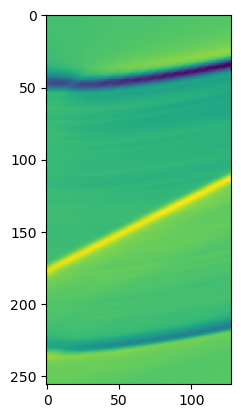

In [66]:
plt.imshow(W_testing[3,0,:,:].cpu().detach().numpy())

In [72]:
ind = 20

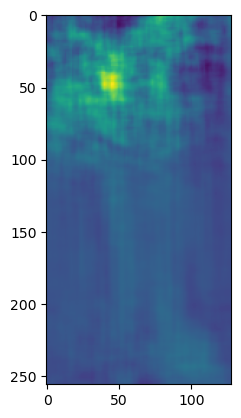

In [73]:
W_out = model([rho_testing[ind:1+ind].to(device=device, dtype=torch.float), scalar_test[ind:1+ind].to(device=device, dtype=torch.float) ])

plt.imshow(W_out[0,0,:,:].cpu().detach().numpy())

In [74]:
W_out.shape

torch.Size([1, 2, 256, 128])

/tmp/ipykernel_1542677/2921197142.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/torch/csrc/utils/tensor_new.cpp:275.)
  noisy_rho = rho_testing[ind:1+ind].to(device=device, dtype=torch.float) + torch.tensor([noise]).to(device).float()


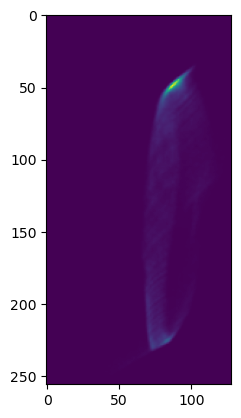

In [75]:
ind = 0;

plt.imshow(rho_testing[0,0,:,:].cpu().detach().numpy())

noise = np.random.normal(5e6, 3e6, (256, 128))
noisy_rho = rho_testing[ind:1+ind].to(device=device, dtype=torch.float) + torch.tensor([noise]).to(device).float()

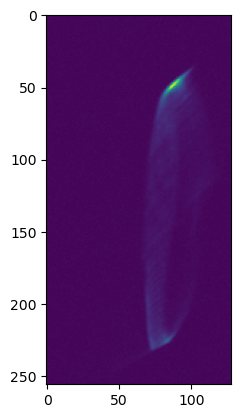

In [76]:
plt.imshow(noisy_rho[0,0,:,:].cpu().detach().numpy())

In [77]:
rho_testing.shape[0]

84

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

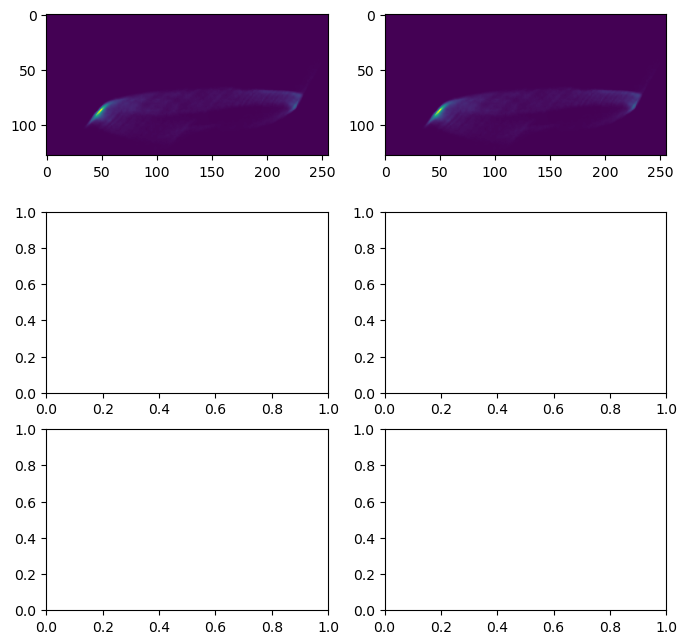

In [78]:
fig, ax = plt.subplots(3,2, figsize = (8,8))
ax[0][0].imshow(rho_testing[ind, 0, : ,:].cpu().detach().numpy().T )
ax[0][1].imshow(rho_testing[ind, 0, : ,:].cpu().detach().numpy().T )

W_0 = model( [rho_testing[ind: ind+1], scalar_test[ind:1+ind] ]).cpu().detach().numpy() ;
W_1 = model( [rho_testing[ind: ind+1], 0*scalar_test[ind:1+ind] ]).cpu().detach().numpy() ;
print(W_0.shape)
ax[1][0].imshow( W_0[0,0,:,:].T )
ax[1][1].imshow( W_1[0,0,:,:].T )

ax[2][0].imshow( W_0[0,1,:,:].T )
ax[2][1].imshow( W_1[0,1,:,:].T )
fig.suptitle("With Scalar Input vs With Scalar Input Zeroed Out")
#ax[1][1].imshow(model([rho_testing[ind, ind+1], scalar_test[ind:1+ind] ]).cpu().detach().numpy() )
plt.savefig("plots/scalars_useless.png")

Image has encoded feature vector of shape  torch.Size([10, 36, 32, 16])


AttributeError: 'FigureCanvasAgg' object has no attribute 'set_window_title'

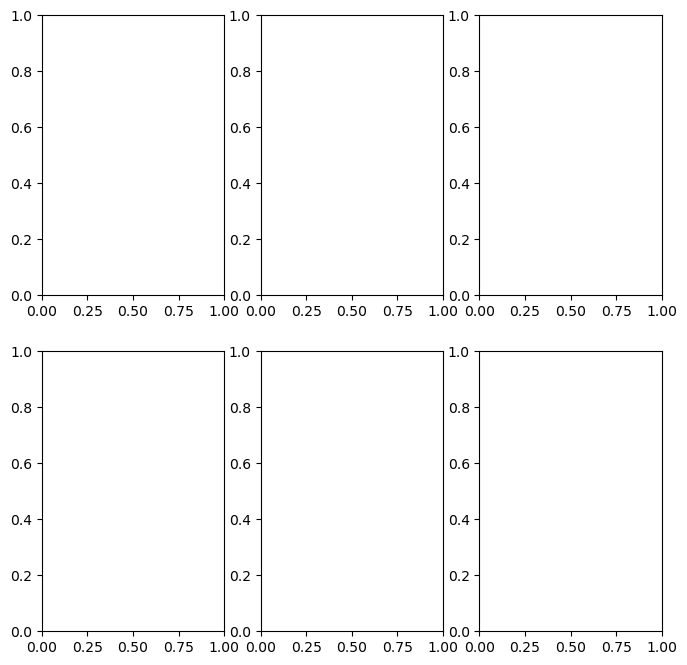

In [79]:
# Take a look at encoder feature map output

output = csr2d_model.encoding_forward([rho_batch, scalar_batch]);
#output = csr2d_model([rho_batch, scalar_batch]);
fig, ax = plt.subplots(2,3, figsize = (8,8));
fig.canvas.set_window_title('Sample feature maps');

ax[0][0].imshow(output[:,1,:,:].data.cpu().mean(axis = 0));
ax[0][1].imshow(output[:,32,:,:].data.cpu().mean(axis = 0));
ax[0][2].imshow(output[:,12,:,:].data.cpu().mean(axis = 0));
ax[1][0].imshow(output[:,29,:,:].data.cpu().mean(axis = 0));
ax[1][1].imshow(output[:,30,:,:].data.cpu().mean(axis = 0));
ax[1][2].imshow(rho_batch[:,0,:,:].cpu().mean(axis = 0))
ax[1][2].set_title('Average Density over Batch');

fig.suptitle('Feature Maps after Encoder');
plt.show();
fig.tight_layout();

torch.Size([10, 2, 256, 128])


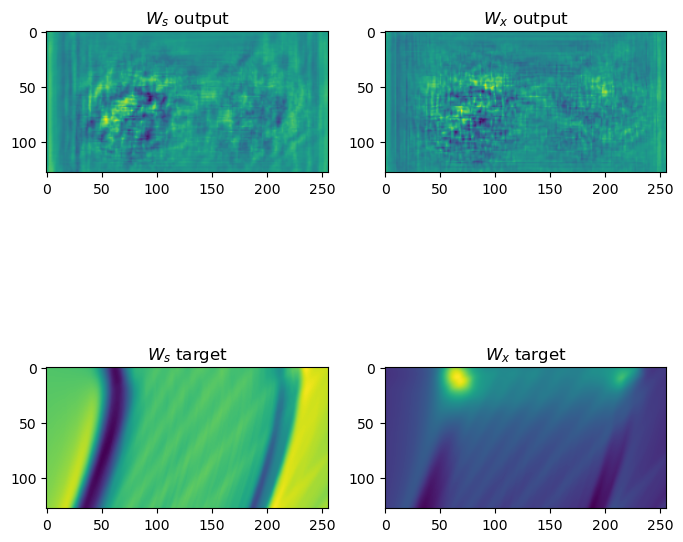

In [81]:
# Take a look at the initial estimates
#output = csr2d_model.encoding_forward([rho_batch, scalar_batch])#csr2d_model([rho_batch, scalar_batch]);
output = csr2d_model.forward([rho_batch, scalar_batch]);
print(output.shape)
fig, ax = plt.subplots(2,2, figsize = (8, 8));
#fig.canvas.set_window_title('Sample feature maps');
ax[0][0].imshow(output[:,0,:,:].data.cpu().mean(axis = 0).T);
ax[0][0].set_title(r'$W_{s}$ output');
ax[0][1].imshow(output[:,1,:,:].data.cpu().mean(axis = 0).T);
ax[0][1].set_title(r'$W_{x}$ output');
ax[1][0].imshow(W_batch[:,0,:,:].data.cpu().mean(axis = 0).T);
ax[1][0].set_title(r'$W_{s}$ target');
ax[1][1].imshow(W_batch[:,1,:,:].data.cpu().mean(axis = 0).T);
ax[1][1].set_title(r'$W_{x}$ target');

#fig.suptitle('Initial guess ');excluded
plt.show();
fig.tight_layout();

In [82]:
#Custom loss functions
class PW_Loss(nn.Module):
    """
    This loss function includes a term to penalize non-zero rotationality of the wake vector field
    """
    def __init__(self):
        super(PW_Loss, self).__init__()
    def PW_error(self, inputs, targets):
        Ws = inputs[0,0,:,:];
        Wx = inputs[0,1,:,:];
        Dx_Ws = torch.gradient(Ws, dim = 1)[0];
        Ds_Wx = torch.gradient(Wx, dim = 0)[0];
        rotW = Dx_Ws - 100*(1e-3)*Ds_Wx;
        diff = rotW.abs();
        err = diff.mean();
        return err;
    def forward(self, inputs, targets):
        loss1 = nn.L1Loss()(inputs, targets);
        loss2 = self.PW_error(inputs, targets);
        loss2 *= 5;
        loss = loss1**2 + loss2**2;
        loss = loss.sqrt();
        return loss
    
class DecoupledLoss(nn.Module):
    """
    In theory the same as L1 loss, just for sanity check
    """
    def __init__(self):
        super(DecoupledLoss, self).__init__()
    def forward(self, inputs, targets):
        Wx_arr = inputs[:,0,:,:];
        Ws_arr = inputs[:,1,:,:];

        target_Wx_arr = targets[:,0,:,:];
        target_Ws_arr = targets[:,1,:,:];
        
        #loss_Wx = sum([ ( (Wx_arr - target_Wx_arr)[i].abs()) for i in range(len(Wx_arr))]).mean();
        loss_Wx = nn.L1Loss()(Wx_arr, target_Wx_arr);
        loss_Ws = nn.L1Loss()(Ws_arr, target_Ws_arr);
        #loss_Ws = sum([( (Ws_arr - target_Ws_arr)[i].abs()) for i in range(len(Ws_arr))]).mean();
        

        loss_tot = loss_Wx + loss_Ws;
        loss_tot += (inputs.max() - targets.max()).abs()/50;
        return loss_tot;
    
class WsLoss1D(nn.Module):
    """
    Penalizes deviations in 1D Ws profile; used as a subroutine in WsLoss
    """
    def __init__(self):
        super(WsLoss1D, self).__init__()
    def forward(self, inputs, targets):
        Ws_arr = inputs.mean(axis = 0);
        Ws_target = targets.mean(axis = 0);
        
        loss = nn.L1Loss()(Ws_target, Ws_arr);
        
        return loss;

class WsLoss(nn.Module):
    """
    Isolates only the longitudinal component, for troubleshooting
    """
    def __init__(self):
        super(WsLoss, self).__init__()
    def forward(self, inputs, targets):
        Ws_arr = inputs[:,0,:,:];
        target_Ws_arr = targets[:,0,:,:];


        loss_Ws = nn.L1Loss()(Ws_arr, target_Ws_arr);
        loss_Ws += WsLoss1D()(Ws_arr, target_Ws_arr);
        loss_tot = loss_Ws;
        
        return loss_tot;
class WxLoss1D(nn.Module):
    """
    Penalizes deviations in 1D Wx profile; used as a subroutine in WsLoss
    """
    def __init__(self):
        super(WxLoss1D, self).__init__()
    def forward(self, inputs, targets):
        Wx_arr = inputs.mean(axis = 0);
        Wx_target = targets.mean(axis = 0);
        
        loss = nn.L1Loss()(Wx_target, Wx_arr);
        
        return loss;
    
class WxLoss(nn.Module):
    """
    Isolates only the transverse component, for troubleshooting
    """
    def __init__(self):
        super(WxLoss, self).__init__()
    def forward(self, inputs, targets):
        Wx_arr = inputs[:,1,:,:];
        target_Wx_arr = targets[:,1,:,:];

        loss_Ws = nn.L1Loss()(Wx_arr, target_Wx_arr);
        loss_Ws += WxLoss1D()(Wx_arr, target_Wx_arr);
        loss_tot = loss_Ws;
        
        return loss_tot;
    
class E_Loss(nn.Module):
    """
    """
    def __init__(self):
        super(E_Loss, self).__init__();
    def forward(self, inputs, targets):
        L = nn.L1Loss()(inputs, targets).square();
        L += (inputs[:,0,:,:].mean() - targets[:,0,:,:].mean()).square();
        L += (inputs[:,1,:,:].mean() - targets[:,1,:,:].mean()).square();
        L = L.sqrt();
        return L;
    
    
class Energy_Convolution(nn.Module):
    def __init__(self):
        super(E_Loss, self).__init__();
    def forward(self, rho, inputs, targets):
        L = rho*(inputs - targets)   

In [207]:
## %%time
# Train the model
torch.autograd.set_detect_anomaly(True)
model = csr2d_model;
model.to(device)

def train(model,optimizer, n_epochs, wait_time = 15):
    best_val_loss = 2e-4;   
    cutoff = 5e-2; #Percent cutoff on validation loss for learning rate reduction
    patience = wait_time; #After patience epochs where val_loss does not increase by more than cutoff, reduce lr

    early_stop_counter = 0;
    prev_val_loss = 0;
    plateau_counter = 0;
    train_loss_arr = np.array([]);
    val_loss_arr = np.array([]);
    lr_arr = np.array([]);
    for epoch in range(n_epochs):
        if early_stop_counter >= patience:
            print("Early stopping triggered, optimal loss reached.")
            return [[train_loss_arr, val_loss_arr], lr_arr]
            break
        if plateau_counter >= 2*patience:
            print("Early stopping triggered on a plateau.")
            return [[train_loss_arr, val_loss_arr], lr_arr]
            break;
        if plateau_counter >= patience:
            print("Reducing learning rate");
            curr_lr = optimizer.state_dict()['param_groups'][0]['lr'];
            optimizer = optim.Adamax(csr2d_model.parameters(), curr_lr/2, weight_decay=1e-4)
            plateau_counter = 0;
        if( (epoch%100) and (epoch > 400) ):
            continue;
            #Reset the learning rate every 100 epochs to jostle our way out of local minima
            #curr_lr = optimizer.state_dict()['param_groups'][0]['lr'];
            #optimizer = optim.Adamax(csr2d_model.parameters(), lr = curr_lr*4, weight_decay=1e-4)
            #Currently disabled
            pass
        csr2d_model.train();
        train_loss = 0.0;
        for inputs in training_dataloader:
            inputs = [x.to(device) for x in inputs]
            optimizer.zero_grad()
            rho_batch, scalar_batch, W_batch = inputs
            rho_batch = rho_batch.float(); scalar_batch = scalar_batch.float(); W_batch = W_batch.float();
            output = csr2d_model([rho_batch, scalar_batch])
            loss = criterion(output, W_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * rho_batch.size(0)
        train_loss /= len(training_dataset)
        train_loss_arr = np.append(train_loss_arr, train_loss);
        csr2d_model.eval()
        val_loss = 0.0
        peak_Ws = np.array([]);
        with torch.no_grad():
            for inputs in val_dataloader:
                inputs = [x.to(device) for x in inputs]
                rho_batch, scalar_batch, W_batch = inputs
                rho_batch = rho_batch.float(); scalar_batch = scalar_batch.float(); W_batch = W_batch.float();
                output = csr2d_model([rho_batch, scalar_batch])
                loss = criterion(output, W_batch)
                val_loss += loss.item() * rho_batch.size(0)
                peak_Ws = np.append(peak_Ws, output[:,0,:,:].abs().max().cpu());
            val_loss /= len(val_dataset)
        val_loss_arr = np.append(val_loss_arr, val_loss);
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, peak value {peak_Ws.max():.6f}")
        #Keep track of whether learning rate is actually improving
        if (epoch >1) and (abs(prev_val_loss - val_loss)/prev_val_loss < cutoff):
            plateau_counter +=1;
        prev_val_loss = val_loss
        #Keep track of whether we've hit the target loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter +1
        else:
            pass;
        #Record the learning rate
        lr_arr = np.append(lr_arr, optimizer.state_dict()['param_groups'][0]['lr']);
    return (train_loss_arr, val_loss_arr), lr_arr;
#############
# Loss   ###
########################################################################
#Adam optimizer with weight decay
criterion = nn.L1Loss();
lr_init = 7e-4;
decay = 0;
optimizer = optim.Adam(model.parameters(), lr = lr_init, weight_decay= decay) 
####################
################
n_epochs = 200;
training_log1 = train(model, optimizer, n_epochs);
#########################################################################
##################
# Rest Loss   ###
########################################################################
#Adam optimizer with weight decay
criterion = E_Loss();
lr_init = 1e-5;
decay = 0;
optimizer = optim.Adam(model.parameters(), lr = lr_init, weight_decay= decay); 
####################
################
n_epochs = 150;
training_log2 = train(model, optimizer, n_epochs);
########################################################################
#Adam optimizer with weight decay
criterion = PW_Loss();
lr_init = 1e-5;
decay = 0;
optimizer = optim.Adam(model.parameters(), lr = lr_init, weight_decay= decay) 
####################
################
n_epochs = 100;
training_log3 = train(model, optimizer, n_epochs);

Epoch 1: Train Loss: 0.421957, Val Loss: 6.765963, peak value 106284.382812
Epoch 2: Train Loss: 0.400477, Val Loss: 6.801982, peak value 83608.914062
Epoch 3: Train Loss: 0.389473, Val Loss: 75.258108, peak value 330470.906250
Epoch 4: Train Loss: 0.383873, Val Loss: 154.906949, peak value 684328.125000
Epoch 5: Train Loss: 0.367497, Val Loss: 8.652800, peak value 100999.296875
Epoch 6: Train Loss: 0.356953, Val Loss: 6.082049, peak value 60658.695312
Epoch 7: Train Loss: 0.348920, Val Loss: 9.548957, peak value 140733.187500
Epoch 8: Train Loss: 0.341473, Val Loss: 17.598838, peak value 225820.859375
Epoch 9: Train Loss: 0.333674, Val Loss: 21.295858, peak value 386329.750000
Epoch 10: Train Loss: 0.326898, Val Loss: 19.575511, peak value 293930.500000
Epoch 11: Train Loss: 0.322437, Val Loss: 2.644253, peak value 38599.167969
Epoch 12: Train Loss: 0.314840, Val Loss: 3.237124, peak value 44931.816406
Epoch 13: Train Loss: 0.308173, Val Loss: 3.495973, peak value 47981.882812
Epoch 1

KeyboardInterrupt: 

In [ ]:
########################################################################
#Adam optimizer with weight decay
criterion = PW_Loss();
lr_init = 1e-5;
decay = 0;
optimizer = optim.Adam(model.parameters(), lr = lr_init, weight_decay= decay) 
####################
################
n_epochs = 100;
training_log3 = train(model, optimizer, n_epochs);

1

In [ ]:
#model_path = '/sdf/home/o/ocamacho/2DCSR_NN_forObed/tracking/NN tracking/model'#r"/sdf/home/o/ocamacho/2DCSR_NN_forObed/tracking/NN tracking";
#state_dict_path = '/sdf/home/o/ocamacho/2DCSR_NN_forObed/tracking/NN tracking/model_state_dict_excluded_phases'
#torch.save(model.state_dict(), state_dict_path)

In [ ]:
#test_model = torch.load(model_path)
#test_model.eval();
#W_out = test_model([rho_batch, scalar_batch]).cpu();

In [ ]:
#plt.imshow(W_out[0,0,:,:].detach().numpy())

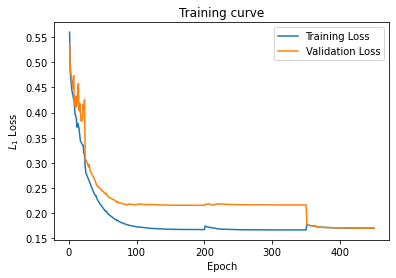

In [175]:
train_loss_arr = np.append(training_log1[0][0], np.append(training_log2[0][0], training_log3[0][0]) );
val_loss_arr   = np.append(training_log1[0][1], np.append(training_log2[0][1], training_log3[0][0]) );
T_arr          = np.linspace(1, len(train_loss_arr), len(train_loss_arr));
lr_arr         = training_log2[1];
plt.plot(T_arr, train_loss_arr, label = 'Training Loss');
plt.plot(T_arr, val_loss_arr, label = 'Validation Loss');
plt.legend();
#plt.ylim(0.10, 0.15)
plt.xlabel('Epoch');
plt.ylabel(r'$L_{1}$ Loss');
plt.title('Training curve');
plt.savefig(r"plots/Loss_curve.png");

In [176]:
Ws_train.abs().mean()

tensor(0.5370, dtype=torch.float64)

Image has encoded feature vector of shape  torch.Size([10, 36, 32, 16])


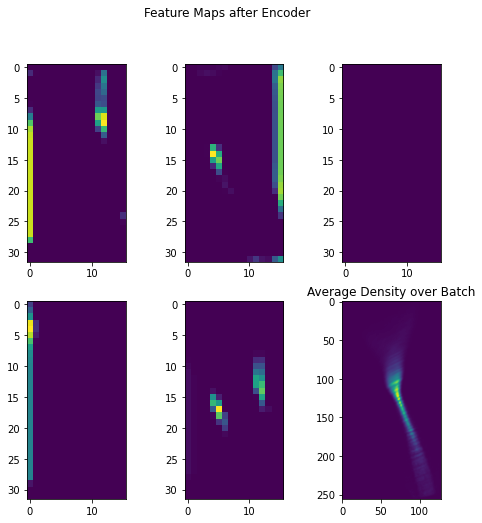

In [208]:
# Take another look at encoder feature map output

output = csr2d_model.encoding_forward([rho_batch, scalar_batch]);
#output = csr2d_model([rho_batch, scalar_batch]);
fig, ax = plt.subplots(2,3, figsize = (8,8));
fig.canvas.set_window_title('Sample feature maps');

ax[0][0].imshow(output[:,0,:,:].data.cpu().mean(axis = 0));
ax[0][1].imshow(output[:,1,:,:].data.cpu().mean(axis = 0));
ax[0][2].imshow(output[:,2,:,:].data.cpu().mean(axis = 0));
ax[1][0].imshow(output[:,3,:,:].data.cpu().mean(axis = 0));
ax[1][1].imshow(output[:,6,:,:].data.cpu().mean(axis = 0));
ax[1][2].imshow(rho_batch[:,0,:,:].cpu().mean(axis = 0))
ax[1][2].set_title('Average Density over Batch');

fig.suptitle('Feature Maps after Encoder');
plt.show();
fig.tight_layout();

### 

In [237]:
#Move testing data to GPU and see how we do
W_testing = W_testing.float()
W_testing = W_testing.to(device)

rho_testing = rho_testing.float();
rho_testing = rho_testing.to(device)

scalar_test = torch.tensor(scalar_test).float();
scalar_test = scalar_test.to(device)
ind = 80;
test_output = csr2d_model([rho_testing[ind:1+ind], scalar_test[ind:1+ind] ])


l = criterion(test_output.to(device), W_batch[ind:1+ind]);

<ipython-input-237-8ba9b91ad133>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scalar_test = torch.tensor(scalar_test).float();


Loss is  tensor(0.2684, device='cuda:0')
tensor(97.2412) percent MAE in the longitudinal wake
Peak longitudinal value of 4.270787715911865 vs 3.9441447257995605
tensor(29.8538) percent MAE in the transverse wake
Peak horizontal value of 6.3035101890563965 vs 4.729522705078125


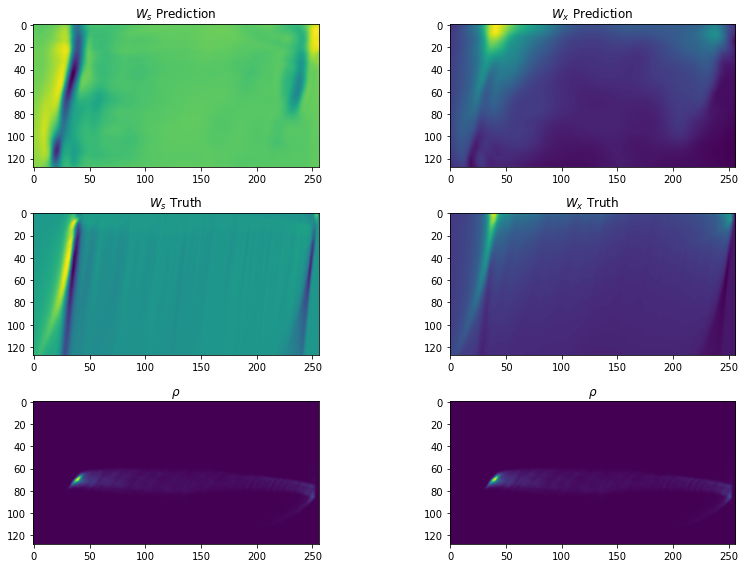

In [238]:
fig,ax = plt.subplots(3,2, figsize = (12,8))

# Show prediction and loss
Ws_output = test_output.data[0,0,:,:].T.cpu();
Wx_output = test_output.data[0,1,:,:].T.cpu();
ax[0,0].imshow(Ws_output)
ax[0,1].imshow(Wx_output)
ax[0,0].set_title('$W_s$ Prediction')
ax[0,1].set_title('$W_x$ Prediction')
loss = criterion(test_output, W_testing[ind: 1+ ind])
print(f"Loss is ", loss.data)

# Show ground truth
Ws_true = W_testing[ind].data[0,:,:].T.cpu();
Wx_true = W_testing[ind].data[1,:,:].T.cpu();
ax[1,0].imshow(Ws_true)
ax[1,1].imshow(Wx_true)
ax[1,0].set_title('$W_s$ Truth')
ax[1,1].set_title('$W_x$ Truth')

# Show input beam
rho_true = rho_testing[ind].data[0,:,:].T.cpu();
#Wx_true = W_train[ind].data[1,:,:].T.cpu();
ax[2,0].imshow(rho_true)
ax[2,1].imshow(rho_true)
ax[2,0].set_title(r'$ \rho $')
ax[2,1].set_title(r'$ \rho $')
fig.tight_layout()

print(100*(Ws_output - Ws_true).abs().mean() /(Ws_true.abs().mean()), "percent MAE in the longitudinal wake" )
print(f"Peak longitudinal value of {Ws_true.abs().max()} vs {Ws_output.abs().max()}")
print(100*(Wx_output - Wx_true).abs().mean() /(Wx_true.abs().mean()),"percent MAE in the transverse wake" )
print(f"Peak horizontal value of {Wx_true.abs().max()} vs {Wx_output.abs().max()}")

In [239]:
W_out = model([rho_testing[0:1],scalar_test[0:1]])

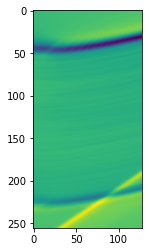

In [240]:
plt.imshow(W_testing[0][0].cpu())

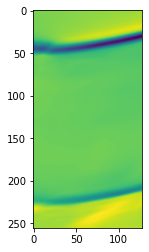

In [241]:
plt.imshow(W_out[0][0].cpu().detach().numpy())

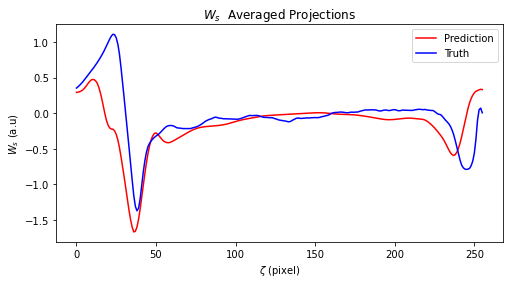

In [242]:
#Take a look at the longitudinal wake
global_mean = W_train.cpu().mean(axis = 0)[0,:,:].T
global_mean.mean(axis = 0);
fig, ax = plt.subplots(1,figsize = (8,4))
Z = np.linspace(0, 255, 256);
ax.plot(Z, Ws_output.mean(axis = 0), label='Prediction', c = 'r')
ax.plot(Z, Ws_true.mean(axis = 0), label='Truth', c = 'b')
#ax.plot(Z, global_mean.mean(axis = 0), label='Global Mean', c = 'g')
ax.set_title(r'$ W_{s} $ ' + ' Averaged Projections')
plt.xlabel(r'$\zeta$ (pixel)')
plt.ylabel(r'$W_{s}$ (a.u)')
ax.legend()
#plt.savefig(r"plots/Ws_projection_baseline_exit.png")#

In [243]:
np.median(np.array([W.abs().max() for W in Ws_train]))

6.8956167421761165

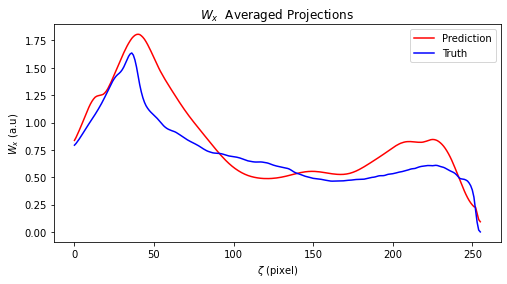

In [244]:
#Take a look at the transverse wake
global_mean = W_train.cpu().mean(axis = 0)[1,:,:].T;
global_mean.mean(axis = 0);
fig, ax = plt.subplots(1,figsize = (8,4));
Z = np.linspace(0, 255, 256);
ax.plot(Z, Wx_output.mean(axis = 0), label='Prediction', c = 'r');
ax.plot(Z, Wx_true.mean(axis = 0), label='Truth', c = 'b');
#ax.plot(Z, Wx_true.mean(axis = 0)/Wx_output.mean(axis = 0), label='Truth', c = 'b');
#ax.plot(Z, global_mean.mean(axis = 0), label='Global Mean', c = 'g')
ax.set_title(r'$ W_{x} $ ' + ' Averaged Projections');
plt.xlabel(r'$\zeta$ (pixel)');
plt.ylabel(r'$W_{x}$ (a.u)');
ax.legend();
#plt.savefig(r"plots/Wx_projection_baseline_exit.png");

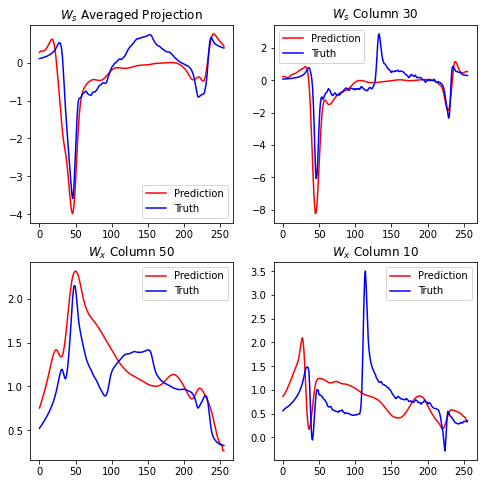

In [223]:
fig, ax = plt.subplots(2,2, figsize = (8,8))
Z = np.linspace(0, 255, 256);
ax[0,0].plot(Z, Ws_output.mean(axis = 0), label='Prediction', c = 'r')
ax[0,0].plot(Z, Ws_true.mean(axis = 0), label='Truth', c = 'b')
ax[0,1].plot(Ws_output[50, :], label='Prediction', c = 'r')
ax[0,1].plot(Ws_true[50, :], label='Truth', c = 'b')
ax[0,0].set_title('$W_s$ Averaged Projection')
ax[0,1].set_title('$W_s$ Column 30')

Z = np.linspace(0, 255, 256);
ax[1,0].plot(Z, Wx_output.mean(axis = 0), label='Prediction', c = 'r')
ax[1,0].plot(Z, Wx_true.mean(axis = 0), label='Truth', c = 'b')
ax[1,0].set_title('$W_x$ Column 50')
ax[1,1].plot(Wx_output[90, :], label='Prediction', c = 'r')
ax[1,1].plot(Wx_true[90, :], label='Truth', c = 'b')
ax[1,1].set_title('$W_x$ Column 10')


ax[1,0].legend()
ax[1,1].legend()
ax[0,0].legend()
ax[0,1].legend()
#plt.savefig(r"plots/W_slice_comparisons.png");

27822.723388671875 pct mean error in $ W_{x} $
9619242.1875 pct mean error in $ W_{s} $


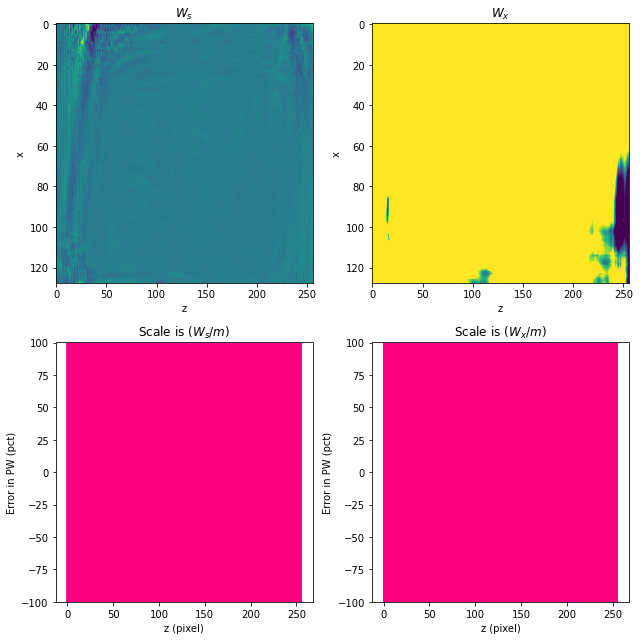

In [118]:
# Looking at Panofsky-Wenzel (curl(W))

Ws = np.array(Ws_output)
Wx = np.array(Wx_output)
#Nz = Ws.shape[0];
#Nx = Ws.shape[1];
#interpolation_points = np.array([[ np.cos((2*k - 1)/Nz) for k in range(Nz)],[np.cos((2*k-1)/Nx) for k in range(Nx)]]);
Dx_Ws = np.gradient(Ws, axis = 1, edge_order = 2);
Dz_Wx = np.gradient(Wx, axis = 0, edge_order = 2);
Ws_scale = np.max(np.abs(Ws))
Wx_scale = np.max(np.abs(Wx))
PW_err = (Dx_Ws - (Dz_Wx)/(1e3) )/(Ws_scale);



fig,ax = plt.subplots(2,2, figsize = (9,9))

cbar_max = 1.2*np.max(np.array(Ws))
cbar_min = 0.90*np.min(np.array(Ws))


ax[0,0].imshow(Ws, vmin=cbar_min, vmax=cbar_max, aspect='auto')
ax[0,0].set_title('$W_s$')
ax[0,0].set_xlabel('z');
ax[0,0].set_ylabel('x');

ax[0,1].imshow(2*Wx, vmin=cbar_min, vmax=cbar_max, aspect='auto')
ax[0,1].set_title('$W_x$')
ax[0,1].set_xlabel('z');
ax[0,1].set_ylabel('x');

#ax[1,0].plot(Wx[:,0], label='$rot(W)$')
for i in range(len(PW_err)):
    ax[1,0].plot(100*PW_err[i]/(Ws[i]), c = (1,0,1-i/len(PW_err.T)))
    #ax[1,0].plot(Ws.T[i]/(1e6), c = (0,0,i/len(PW_err.T)))
ax[1,0].set_ylim(-100,100);
ax[1,0].set_title('Scale is $(W_{s}/m$)')
ax[1,0].set_xlabel('z (pixel)')
ax[1,0].set_ylabel('Error in PW (pct)')
for i in range(len(PW_err)):
    ax[1,1].plot(100*PW_err[i]/(Wx[i]), c = (1,0,1-i/len(PW_err.T)))
    #ax[1,0].plot(Ws.T[i]/(1e6), c = (0,0,i/len(PW_err.T)))
ax[1,1].set_ylim(-100,100);
ax[1,1].set_title('Scale is $(W_{x}/m$)')
ax[1,1].set_xlabel('z (pixel)')
ax[1,1].set_ylabel('Error in PW (pct)')

fig.tight_layout()
print(100*np.mean(np.abs(PW_err)/np.abs(Wx)), r"pct mean error in $ W_{x} $")
print(100*np.mean(np.abs(PW_err)/np.abs(Ws)), r"pct mean error in $ W_{s} $")

# Everything past here is markdown, mostly older versions of functions and procedures

%%time

def load_step(file, n_step): # load one step from a simulation file 
    file_name = f'bigger_results/{file}'#f'2DCSR_NN_lucretia/{file}'
    h5 = h5py.File(file_name, 'r')

    result = h5['csr_result']
    #print(result.keys())
    nz, nx = result["Ws_grid_list"][n_step].T.shape ## number of grid points in z and x for wakes 
    nz_cg, nx_cg = result["lambda_grid_list"][n_step].T.shape ## number of grid points in z and x for beam density 
    ## lambda and rho both refer to beam density
    zmin = result["zmin_list"][n_step] ## minimum z coordinate
    zmax = result["zmax_list"][n_step]
    xmin = result["xmin_list"][n_step]
    xmax = result["xmax_list"][n_step]

    zv = np.linspace(zmin, zmax, nz);
    xv = np.linspace(xmin, xmax, nx);

    zv_cg = np.linspace(zmin, zmax, nz_cg);
    xv_cg = np.linspace(xmin, xmax, nx_cg);

    Ws_grid = result["Ws_grid_list"][n_step].T
    Wx_grid = result["Wx_grid_list"][n_step].T
    lambda_grid = result["lambda_grid_list"][n_step].T

    s = np.array(result["s_at_kick_list"])[n_step]
    
    return xv, zv, Ws_grid, Wx_grid, lambda_grid, s

ns = np.arange(20)  # 20 steps per simulation

Ws_test_data = []
Wx_test_data = []
rho_test_data = []
dx_test_data = []
dz_test_data = []
s_test_data = []

for j, file in enumerate(os.listdir('bigger_results')):
    if file.startswith('result'):
        for i, n in enumerate(ns):
            xv, zv, Ws, Wx, rho, s = load_step(file, n)
            Ws = Ws[:-1, :-1]
            Wx = Wx[:-1, :-1]
            rho = rho[:]

            dx = np.mean(np.diff(xv))  # Physical scaling in x
            dz = np.mean(np.diff(zv))  # Ditto in y

            Ws = np.expand_dims(Ws, axis= 0)    # Add a new axis at the beginning
            Wx = np.expand_dims(Wx, axis= 0)    # Ditto
            rho = np.expand_dims(rho, axis= 0)  # Ditto
            #print(Ws.shape)
            if i == 0 and j == 0:
                Ws_test_data = torch.from_numpy(Ws)
                Wx_test_data = torch.from_numpy(Wx)
                rho_test_data = torch.from_numpy(rho)
                dx_test_data = torch.from_numpy(np.array([dx]))
                dz_test_data = torch.from_numpy(np.array([dz]))
                s_test_data = torch.from_numpy(np.array([s]))
            else:
                Ws_test_data = torch.cat((torch.from_numpy(Ws), Ws_test_data), dim= 0)
                #plt.imshow(Wx_data[:,:,0])
                Wx_test_data = torch.cat((torch.from_numpy(Wx), Wx_test_data), dim= 0)
                rho_test_data = torch.cat((torch.from_numpy(rho), rho_test_data), dim= 0)
                dx_test_data = torch.cat((torch.from_numpy(np.array([dx])), dx_test_data))
                dz_test_data = torch.cat((torch.from_numpy(np.array([dz])), dz_test_data))
                s_test_data = torch.cat((torch.from_numpy(np.array([s])), s_test_data))
Ws_test_data = torch.unsqueeze(Ws_test_data, dim=1)
Wx_test_data = torch.unsqueeze(Wx_test_data, dim=1)
rho_test_data = torch.unsqueeze(rho_test_data, dim=1)
print(Ws_test_data.shape)

class CSR2D(nn.Module):
    """
    model = nn.Sequential(
          nn.Conv2d(1,20,5),
          nn.ReLU(),
          nn.Conv2d(20,64,5),
          nn.ReLU()
        )
    """
    def __init__(self):
        super().__init__()
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
            return;
        # takes in a module and applies the specified weight initialization
        def weights_init_uniform_rule(m):
            classname = m.__class__.__name__
            # for every Linear layer in a model..
            if classname.find('Linear') != -1:
                # get the number of the inputs
                n = m.in_features
                y = 1.0/np.sqrt(n)
                m.weight.data.uniform_(-y, y)
                m.bias.data.fill_(0)        
        #######################################################################
        
        ############
        # Encoder #
        ##########
        #Understand this bit in detail
        encoding_dim = 12 # Length of final encoded feature vector
        num_conv = 7;     # Number of convolutional layers
        outchannels = 2     #
        nfilters = 32;
        kernel_sizes = [3,7]#[3, 7]
        pool_size = 2
        activation = nn.ReLU();
        encoder_layers = [nn.Conv2d(1, nfilters, kernel_sizes, padding='same')]
        for i in range(num_conv -1):
            encoder_layers.append(nn.Conv2d(nfilters, nfilters, kernel_sizes, padding='same'))
            encoder_layers.append(activation)
            #for kernel_size in kernel_sizes:
            #    encoder_layers.append(nn.Conv2d(nfilters, nfilters, kernel_sizes, padding='same'))
            #    encoder_layers.append(activation)
            encoder_layers += [nn.BatchNorm2d(nfilters)]
            encoder_layers += [nn.MaxPool2d(2)]
        encoder_layers.append(nn.Flatten())
        #I'm not sure how the shape here is determined
        encoder_layers.append(nn.Linear(2**(num_conv+1) , encoding_dim))
        encoder_layers.append(activation)

        self.encoder = nn.Sequential(*encoder_layers)
        self.encoder.apply(weights_init_uniform_rule)
        #######################
        # Intermediate Layer #
        #####################
        """
        Takes 1D feature + parameter array as input
        Produces a 2 channel 32x16 image as output
        
        ISSUE: Something in here puts a lot of activation into the edges of the image
        """
        num_dense = 3
        small_dim_power2 = 4
        num_units = 400
        activation = nn.ReLU()

        dense_layers = []
        dense_layers.append(nn.Linear(encoding_dim + 4 ,num_units));
        for i in range(1,num_dense):
            dense_layers.append(nn.Linear(num_units, num_units))
            dense_layers.append(activation)
        dense_layers.append(nn.Linear(num_units, 8*4)  )
        dense_layers.append(activation)
        
        class Reshape(nn.Module):
            def __init__(self, shape):
                super(Reshape, self).__init__()
                self.shape = shape

            def forward(self, x):
                return x.view(x.size(0), *self.shape)

        dense_layers.append(Reshape((1, 8, 4)) );
        self.intermediate = nn.Sequential(*dense_layers)
        self.intermediate.apply(weights_init_uniform_rule)
        ############
        # Decoder #
        ##########
        num_deconv = 7 - small_dim_power2;
        nfilters = 64
        kernel_sizes = [3,  3]
        pool_size = 2
        decoder_layers = []
        decoder_layers.append(nn.ConvTranspose2d(1, nfilters, kernel_sizes, padding= (0,0) ))
        for i in range(num_deconv):
            for kernel_size in kernel_sizes:
                decoder_layers.append(nn.ConvTranspose2d(nfilters, nfilters, kernel_size, padding= (0,0)))
                decoder_layers.append(activation)
            decoder_layers.append(nn.BatchNorm2d(nfilters))
            decoder_layers.append(nn.Upsample(scale_factor=pool_size))

        decoder_layers.append(nn.Conv2d(nfilters, 2, kernel_size= (3, 3), padding= (0,0)))
    
        self.decoder = nn.Sequential(*decoder_layers)
        self.decoder.apply(weights_init_uniform_rule)
    ##########################################################################
    
    def forward(self, inputs):
        img_inputs = inputs[0];
        scalar_inputs= inputs[1];
        encoded_flattened = self.encoder(img_inputs);
        #print(f"Image has encoded feature vector of shape ", encoded_flattened.shape);
        concatenated = torch.cat((encoded_flattened, scalar_inputs), dim=1)
        #print(f"Combined feature + param vector has shape ", concatenated.shape);
        afterNN = self.intermediate(concatenated);
        #print(f"Densely encoded output has shape ", afterNN.shape);
        decoded = self.decoder(afterNN);
        #print(f"Decoded output has shape ", decoded.shape);
        decoded = torchvision.transforms.Resize((256,128))(decoded);
        #print(f"Output has shape ", decoded.shape);
        return decodedclass CSR2D(nn.Module):
    """
    model = nn.Sequential(
          nn.Conv2d(1,20,5),
          nn.ReLU(),
          nn.Conv2d(20,64,5),
          nn.ReLU()
        )
    """
    def __init__(self):
        super().__init__()
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
            return;
        # takes in a module and applies the specified weight initialization
        def weights_init_uniform_rule(m):
            classname = m.__class__.__name__
            # for every Linear layer in a model..
            if classname.find('Linear') != -1:
                # get the number of the inputs
                n = m.in_features
                y = 1.0/np.sqrt(n)
                m.weight.data.uniform_(-y, y)
                m.bias.data.fill_(0)        
        #######################################################################
        
        ############
        # Encoder #
        ##########
        #Understand this bit in detail
        encoding_dim = 12 # Length of final encoded feature vector
        num_conv = 7;     # Number of convolutional layers
        outchannels = 2     #
        nfilters = 32;
        kernel_sizes = [3,7]#[3, 7]
        pool_size = 2
        activation = nn.ReLU();
        encoder_layers = [nn.Conv2d(1, nfilters, kernel_sizes, padding='same')]
        for i in range(num_conv -1):
            encoder_layers.append(nn.Conv2d(nfilters, nfilters, kernel_sizes, padding='same'))
            encoder_layers.append(activation)
            #for kernel_size in kernel_sizes:
            #    encoder_layers.append(nn.Conv2d(nfilters, nfilters, kernel_sizes, padding='same'))
            #    encoder_layers.append(activation)
            encoder_layers += [nn.BatchNorm2d(nfilters)]
            encoder_layers += [nn.MaxPool2d(2)]
        encoder_layers.append(nn.Flatten())
        #I'm not sure how the shape here is determined
        encoder_layers.append(nn.Linear(2**(num_conv+1) , encoding_dim))
        encoder_layers.append(activation)

        self.encoder = nn.Sequential(*encoder_layers)
        self.encoder.apply(weights_init_uniform_rule)
        #######################
        # Intermediate Layer #
        #####################
        """
        Takes 1D feature + parameter array as input
        Produces a 2 channel 32x16 image as output
        
        ISSUE: Something in here puts a lot of activation into the edges of the image
        """
        num_dense = 3
        small_dim_power2 = 4
        num_units = 400
        activation = nn.ReLU()

        dense_layers = []
        dense_layers.append(nn.Linear(encoding_dim + 4 ,num_units));
        for i in range(1,num_dense):
            dense_layers.append(nn.Linear(num_units, num_units))
            dense_layers.append(activation)
        dense_layers.append(nn.Linear(num_units, 8*4)  )
        dense_layers.append(activation)
        
        class Reshape(nn.Module):
            def __init__(self, shape):
                super(Reshape, self).__init__()
                self.shape = shape

            def forward(self, x):
                return x.view(x.size(0), *self.shape)

        dense_layers.append(Reshape((1, 8, 4)) );
        self.intermediate = nn.Sequential(*dense_layers)
        self.intermediate.apply(weights_init_uniform_rule)
        ############
        # Decoder #
        ##########
        num_deconv = 7 - small_dim_power2;
        nfilters = 64
        kernel_sizes = [3,  3]
        pool_size = 2
        decoder_layers = []
        decoder_layers.append(nn.ConvTranspose2d(1, nfilters, kernel_sizes, padding= (0,0) ))
        for i in range(num_deconv):
            for kernel_size in kernel_sizes:
                decoder_layers.append(nn.ConvTranspose2d(nfilters, nfilters, kernel_size, padding= (0,0)))
                decoder_layers.append(activation)
            decoder_layers.append(nn.BatchNorm2d(nfilters))
            decoder_layers.append(nn.Upsample(scale_factor=pool_size))

        decoder_layers.append(nn.Conv2d(nfilters, 2, kernel_size= (3, 3), padding= (0,0)))
    
        self.decoder = nn.Sequential(*decoder_layers)
        self.decoder.apply(weights_init_uniform_rule)
    ##########################################################################
    
    def forward(self, inputs):
        img_inputs = inputs[0];
        scalar_inputs= inputs[1];
        encoded_flattened = self.encoder(img_inputs);
        #print(f"Image has encoded feature vector of shape ", encoded_flattened.shape);
        concatenated = torch.cat((encoded_flattened, scalar_inputs), dim=1)
        #print(f"Combined feature + param vector has shape ", concatenated.shape);
        afterNN = self.intermediate(concatenated);
        #print(f"Densely encoded output has shape ", afterNN.shape);
        decoded = self.decoder(afterNN);
        #print(f"Decoded output has shape ", decoded.shape);
        decoded = torchvision.transforms.Resize((256,128))(decoded);
        #print(f"Output has shape ", decoded.shape);
        return decoded

class CSR2D(nn.Module):
    def __init__(self):
        super().__init__()
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
            return;
        # takes in a module and applies the specified weight initialization
        def weights_init_uniform_rule(m):
            classname = m.__class__.__name__
            # for every Linear layer in a model..
            if classname.find('Linear') != -1:
                # get the number of the inputs
                n = m.in_features
                mu = 0;
                y = 1.0/np.sqrt(n)
                m.weight.data.uniform_(mu-y,mu+ y)
                m.bias.data.fill_(0)      
            
        ######################################################################################
        ######################################################################################
        
        ############
        # Encoder #
        ##########
        #Understand this bit in detail
        encoding_dim = 32     # Length of final encoded feature vector
        num_conv = 7;           # Number of convolutional layers
        outchannels = 2;       #
        nfilters = 32;
        kernel_sizes = [3,7];   #[3, 7]
        pool_size = 2;
        activation = nn.CELU();
        #output_dims = (8, 4);
        encoder_layers = [nn.Conv2d(1, nfilters, 2, padding='same')]
        for i in range(num_conv -1):
            #encoder_layers.append(nn.Conv2d(nfilters, nfilters, kernel_sizes, padding='same'));
            #encoder_layers.append(activation) ;
            for kernel_size in kernel_sizes:
                encoder_layers.append(nn.Conv2d(nfilters, nfilters, kernel_size, padding='same'))
                encoder_layers.append(activation)
            encoder_layers += [nn.BatchNorm2d(nfilters)] ;
            encoder_layers += [nn.MaxPool2d(2)] ;
        #encoder_layers.append(nn.Flatten()) ;
        #Output has length 2**(num_conv +1)
        #encoder_layers.append(nn.Linear(2**(num_conv+1) , encoding_dim)) ;
        #encoder_layers.append(activation) ;
        

        self.encoder = nn.Sequential(*encoder_layers) ;
        #self.encoder.apply(weights_init_uniform_rule)
        
        #######################
        # Intermediate Layer #
        #####################
        """
        Takes 1D feature + parameter array as input
        Produces a 2 channel 32x16 image as output
        
        ISSUE: Something in here puts a lot of activation into the edges of the image
        TODO: See if keeping geometric info (i.e. not collapsing encoder into a 1xN vector) yields better performance
        """
        num_dense = 2;
        small_dim_power2 = 4;
        num_units = 500;
        activation = nn.ReLU();
        output_dims = (32,16);
        dense_layers = [];
        dense_layers.append(nn.Linear( encoding_dim +  4,num_units) );
        dense_layers.append( activation );
        for i in range(1,num_dense):
            dense_layers.append( nn.Linear(num_units, num_units) );
            dense_layers.append( activation );
        dense_layers.append( nn.Linear(num_units, output_dims[0]*output_dims[1])  );
        
        #dense_layers.append( activation );
        
        class Reshape(nn.Module):
            def __init__(self, shape):
                super(Reshape, self).__init__()
                self.shape = shape;
            def forward(self, x):
                return x.view(x.size(0), *self.shape);
        dense_layers.append(Reshape((1, output_dims[0], output_dims[1])) );
        self.intermediate = nn.Sequential(*dense_layers)
        #self.intermediate.apply(weights_init_uniform_rule)
        
        ############
        # Decoder #
        ##########
        num_deconv = 3; #7 - small_dim_power2;
        nfilters = 32;
        kernel_sizes = [2, 4];
        pool_size = 2;
        decoder_layers = [];
        decoder_layers.append(nn.ConvTranspose2d(1, nfilters, kernel_sizes, padding= (1,0) ));
        activation = nn.ReLU();
        decoder_layers.append(activation);
        decoder_layers.append(nn.Conv2d(nfilters, 2, kernel_size= (3, 7), padding= (0,0)));
        pads = [1,0,0];
        for i in range(3):
            for kernel_size in kernel_sizes:
                decoder_layers.append(nn.ConvTranspose2d(2, 2, kernel_size, padding= (pads[i], pads[i])) );
                decoder_layers.append(activation);
            decoder_layers.append(nn.BatchNorm2d(2));
            decoder_layers.append(nn.Upsample(scale_factor=pool_size))
        decoder_layers.append(nn.Conv2d(2, 2, kernel_size= (3, 7), padding= (0,0)));
        self.decoder = nn.Sequential(*decoder_layers);
        #self.decoder.apply(weights_init_uniform_rule)
    ##########################################################################
    
    def forward(self, inputs):
        img_inputs = inputs[0];
        scalar_inputs= inputs[1];
        encoded_flattened = self.encoder(img_inputs);
        return encoded_flattened
        #print(f"Image has encoded feature vector of shape ", encoded_flattened.shape);
        #concatenated = torch.cat((encoded_flattened, scalar_inputs), dim=1)
        #print(f"Combined feature + param vector has shape ", concatenated.shape);
        afterNN = self.intermediate(concatenated);
        #print(f"Densely encoded output has shape ", afterNN.shape);
        decoded = self.decoder(afterNN);
        #print(f"Decoded output has shape ", decoded.shape);
        decoded = torchvision.transforms.Resize((256,128))(decoded);
        #print(f"Output has shape ", decoded.shape);
        return decoded;

class CSR2D(nn.Module):
    def __init__(self):
        super().__init__()
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.uniform_(m.weight)
                m.bias.data.fill_(1)
            return;

        def weights_init_uniform_rule(m):
            #Alternative initialization procedure initiates weights uniformly; doesn't seem to make much of a difference
            classname = m.__class__.__name__
            if classname.find('Linear') != -1:
                # get the number of the inputs
                n = m.in_features
                mu = np.exp(n);
                y = 1.0/np.sqrt(n)
                m.weight.data.uniform_(mu-y,mu+ y)
                m.bias.data.fill_(0)      
            
        ######################################################################################
        ######################################################################################
        
        ##################
        # Encoder     ###
        ################
        """
        Takes 256x128 density input, applies alternating high (3x3) and low (7x7) convolution + maxpooling to
        produce a (2**(8- num_conv), 2**(8 - num_conv -1)) image with n_filters channels
        
        ISSUE: These activations keep dying, fast! What gives?
        
        """
        num_conv = 3;           # Number of convolutional layers
        nfilters = 8;
        kernel_sizes = (3,7);   #[3, 7]
        pool_size = 2;
        activation = nn.ReLU();
        #Input layer
        encoder_layers = [];
        #for kernel_size in kernel_sizes:
        encoder_layers.append(nn.Conv2d(1, nfilters, kernel_sizes[0], padding='same'))
        encoder_layers.append(activation)
        encoder_layers += [nn.BatchNorm2d(nfilters)] ;
        encoder_layers += [nn.MaxPool2d(2)] ;
            
        for i in range(num_conv-1):
            for kernel_size in kernel_sizes:
                encoder_layers.append(nn.Conv2d(nfilters, nfilters, kernel_size, padding='same'))
                encoder_layers.append(activation)
            encoder_layers += [nn.BatchNorm2d(nfilters)] ;
            encoder_layers += [nn.MaxPool2d(2)] ;
        
        self.encoder = nn.Sequential(*encoder_layers) ;
        self.encoder.apply(weights_init_uniform_rule)
        #######################
        # Flatten          ###
        #####################
        """
        Pretty self explanatory. Takes in the output of the encoder and flattens into a linear data structure,
        of length  encoded_dims[0] * encoded_dims[1] * nfilters, suitable for a linear dense NN
        
        The scalar parameter vector is appended to this vector afterward
        """
        encoding_dim = 8     # Length of final encoded feature vector
        encoded_dims = (2**(8- num_conv), 2**(8 - num_conv -1));
        flattened_dim = encoded_dims[0] * encoded_dims[1] * nfilters;
        flatten = [];
        flatten.append(nn.Flatten());
        flatten.append(nn.Linear(flattened_dim, encoding_dim));
        flatten.append(activation);
        #self.flatten = nn.Sequential(*flatten);
        
        #########################
        # Intermediate Layer ###
        #######################
        """
        Takes 1D feature + parameter array of length  encoded_dims[0] * encoded_dims[1] * nfilters
        In the final layer, the num_units output vector is unflattened into a single channel 32x16 image
        
        TODO: See if keeping geometric info (i.e. not collapsing encoder into a 1xN vector) yields better performance
        """
        num_dense = 2;
        num_scalars = 4;
        num_units = 128;
        activation = nn.Tanh();
        output_dims = (16,8);
        dense_layers = [];
        dense_layers.append(nn.Linear( encoding_dim + num_scalars , num_units) );
        dense_layers.append(activation);
        for i in range(1,num_dense):
            dense_layers.append( nn.Linear(num_units, num_units) );
            dense_layers.append( activation );
        dense_layers.append( nn.Linear(num_units, output_dims[0]*output_dims[1])  );
        dense_layers.append( activation );
        dense_layers.append(nn.Unflatten(1, (1,32,16) )   );
        dense_layers.append( activation );
        self.intermediate = nn.Sequential(*dense_layers)
        #self.intermediate.apply(weights_init_uniform_rule)
        
        ############
        # Decoder #
        ##########
        """
        Takes the 1x32x16 output of the dense layer, splits it into nfilters channels, performs convolution+upsampling,
        and collapses into a two channel output image with approximate 2:1 aspect ratio
        """
        num_deconv = 4; 
        kernel_sizes = (3, 8);
        pool_size = 2;
        activation = nn.Tanh();
        decoder_layers = [];
        decoder_layers.append(nn.ConvTranspose2d(nfilters, 2, kernel_sizes[0], padding= (2,1) ));
        #decoder_layers.append(nn.ConvTranspose2d(nfilters, nfilters//2, kernel_sizes[0], padding= (0,0) ));
        #decoder_layers.append(activation);
        #decoder_layers.append(nn.Conv2d(nfilters//2, 2, kernel_sizes[1], padding= (0,0)));
        #decoder_layers.append(activation);
        pads = [1,2,4];
        for i in range(1, num_deconv):
            for kernel_size in kernel_sizes:
                decoder_layers.append(nn.ConvTranspose2d(2, 2, kernel_size, padding= (pads[i%3], pads[i%3])) );
                decoder_layers.append(activation);
            decoder_layers.append(nn.BatchNorm2d(2));
            decoder_layers.append(nn.Upsample(scale_factor=pool_size))
        self.decoder = nn.Sequential(*decoder_layers);
        #self.decoder.apply(weights_init_uniform_rule)
    ##########################################################################
    
    def forward(self, inputs):
        img_inputs = inputs[0];
        scalar_inputs= inputs[1];
        encoded = self.encoder(img_inputs);
        #print(f"Feature map has encoded feature vector of shape ", encoded.shape);
        decoded = self.decoder(encoded);
        #print(f"Decoded output has shape ", decoded.shape);
        decoded = torchvision.transforms.Resize((256,128))(decoded);
        #print(f"Output has shape ", decoded.shape);
        return decoded;
    def encoding_forward(self, inputs):
        img_inputs = inputs[0];
        scalar_inputs= inputs[1];
        encoded_flattened = self.encoder(img_inputs);
        print(f"Image has encoded feature vector of shape ", encoded_flattened.shape);
        return encoded_flattened